In [1]:
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import sys

from Bio import SeqIO
from datetime import datetime

from torch.utils import data
#from data_generator import data_generator
from data_generator import Dataset
from lstm import LSTM_model
from lstm import LSTMCell
from alpha_set import alpha_set
from print_seq import print_seq

In [2]:
#acids = "abcdefghijklmnopqrstuvwxyz-"
acids = "ACDEFGHIKLMNOPQRSTUVWY-"
large_file = "uniref50.fasta"
small_file = "100k_rows.fasta"
test_file = "test.fasta"

#max_seq_len = 50
max_seq_len = 2000

# Good sizes: 16/700 or 32/400 on laptop
# 32/1500 on desktop
batch_size = 32
hidden_dim = 400

hidden_layers = 1

# Use Cuda if available
use_cuda = torch.cuda.is_available() and True
print("Using GPU:", use_cuda)
processor = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True


# Initialising data generator
dataset = Dataset(small_file, max_seq_len, acids=acids)
#dataset = alpha_set(acids, max_seq_len, 3200)
base_generator = data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialising for training
model = LSTM_model(len(acids), hidden_dim, hidden_layers, max_seq_len, batch_size, processor).to(processor)
loss_function = nn.CrossEntropyLoss(reduction="mean").to(processor)
optimiser = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=True)

# Best lr so far is 2e-2
#optimiser = optim.Adam(model.parameters(), lr=5e-4, weight_decay=0.001)

Using GPU: True


In [6]:
# Initialising some variables for use in training
batches = 3000
time_diff = 0
no_improv = 0
min_loss = float("inf")
loss_list = []

print_stuff = True

# Main training loop
for i, (batch, labels, valid_elems) in enumerate(base_generator):

    # Keeping track of stuff
    start_time = datetime.now()
    sys.stdout.write("\rBatch: {0}. Min loss: {1:.5f}. Estimated time left: {2}. Batches since improvement: {3}.".format(i+1, min_loss, time_diff*(batches - i), no_improv))

    # Putting data on gpu
    batch = batch.to(processor)
    labels = labels.to(processor)
    valid_elems = valid_elems.to(processor)

    # Transposing from (batch x seq x feature_size) to (seq x batch x feature_size)
    batch = batch.transpose(0, 1)

    # Resetting gradients
    model.train()
    model.zero_grad()
    
    if i == 0 and print_stuff:
        print("Input:\t", batch.size())
        print("Labels:\t", labels.size())
        print("Valid:\t", valid_elems)

    batch = rnn.pack_padded_sequence(batch, valid_elems, enforce_sorted=False)
    labels = rnn.pack_padded_sequence(labels, valid_elems, enforce_sorted=False, batch_first=True)

    out, hidden = model(batch)

    out = rnn.pack_padded_sequence(out, valid_elems, enforce_sorted=False)
    if i == 0 and print_stuff:
        print("Output:\t", out.data.size())
        print("Hidden:\t", hidden.data.size())


    #print(out.data.size())
    #print(labels.data.size())
    loss = loss_function(out.data, labels.data)
    
    '''
    # This bit is replaced by packing labels and the line above
    # Backpropping only through the non-padded parts
    loss = 0
    for j in range(out.size()[1]):
        #print(out.size())
        #print(torch.narrow(out, 1, j, 1).squeeze(1).size())
        
        narrowed_out = torch.narrow(torch.narrow(out, 1, j, 1).squeeze(1), 0, 0, valid_elems[j])
        narrowed_labels = torch.narrow(labels[j], 0, 0, valid_elems[j])

        #print_seq(narrowed_out[0].view(1,2000,23))
        
        print(narrowed_out.size())
        print(narrowed_labels.size())
        loss += loss_function(narrowed_out, narrowed_labels)
    '''
    #loss /= out.size()[1]

    loss_list.append(loss.item())
    loss.backward()
    optimiser.step()

    if loss.item() < min_loss:
        torch.save(model.state_dict(), "model.pth")
        min_loss = loss.item()
        no_improv = 0
    else:
        no_improv += 1
        
    
    
    # For tracking progress
    end_time = datetime.now()
    time_diff = end_time - start_time
    
    # Breaking when it's run through the given number of batches
    if i+1 >= batches:
        break

Batch: 1. Min loss: inf. Estimated time left: 0. Batches since improvement: 0.Input:	 torch.Size([2000, 32, 23])
Labels:	 torch.Size([32, 2000])
Valid:	 tensor([ 294,  470,  508, 1025,  168,  222,  403,  525,  272,  191, 1258,  776,
          61,  260,  544,   95,  135,  199,  358,  242,  722,  233,  304,  176,
         113,  880,  189,  466,   56,  294,  155,  181], device='cuda:0')
Output:	 torch.Size([11775, 23])
Hidden:	 torch.Size([11775, 400])


Batch: 2. Min loss: 3.07962. Estimated time left: 0:27:48.340701. Batches since improvement: 0.

Batch: 3. Min loss: 3.07926. Estimated time left: 0:34:24.599682. Batches since improvement: 0.

Batch: 4. Min loss: 3.07926. Estimated time left: 0:29:59.287911. Batches since improvement: 1.

Batch: 5. Min loss: 3.07813. Estimated time left: 0:23:29.773792. Batches since improvement: 0.

Batch: 6. Min loss: 3.07739. Estimated time left: 0:34:56.970215. Batches since improvement: 0.

Batch: 7. Min loss: 3.07739. Estimated time left: 0:25:14.401128. Batches since improvement: 1.

Batch: 8. Min loss: 3.07739. Estimated time left: 0:27:26.874306. Batches since improvement: 2.

Batch: 9. Min loss: 3.07739. Estimated time left: 0:24:34.179344. Batches since improvement: 3.

Batch: 10. Min loss: 3.07739. Estimated time left: 0:32:12.978615. Batches since improvement: 4.

Batch: 11. Min loss: 3.07739. Estimated time left: 0:26:36.555350. Batches since improvement: 5.

Batch: 12. Min loss: 3.07739. Estimated time left: 0:25:34.908291. Batches since improvement: 6.

Batch: 13. Min loss: 3.07739. Estimated time left: 0:34:50.700612. Batches since improvement: 7.

Batch: 14. Min loss: 3.07739. Estimated time left: 0:26:16.150290. Batches since improvement: 8.

Batch: 15. Min loss: 3.07739. Estimated time left: 0:35:05.386796. Batches since improvement: 9.

Batch: 16. Min loss: 3.07739. Estimated time left: 0:23:46.456875. Batches since improvement: 10.

Batch: 17. Min loss: 3.07739. Estimated time left: 0:27:24.927016. Batches since improvement: 11.

Batch: 18. Min loss: 3.07739. Estimated time left: 0:22:57.000528. Batches since improvement: 12.

Batch: 19. Min loss: 3.07739. Estimated time left: 0:30:26.850732. Batches since improvement: 13.

Batch: 20. Min loss: 3.07739. Estimated time left: 0:32:38.406703. Batches since improvement: 14.

Batch: 21. Min loss: 3.07739. Estimated time left: 0:34:32.944620. Batches since improvement: 15.

Batch: 22. Min loss: 3.07739. Estimated time left: 0:34:56.894268. Batches since improvement: 16.

Batch: 23. Min loss: 3.07739. Estimated time left: 0:33:32.687256. Batches since improvement: 17.

Batch: 24. Min loss: 3.07739. Estimated time left: 0:29:08.996431. Batches since improvement: 18.

Batch: 25. Min loss: 3.07739. Estimated time left: 0:21:18.805056. Batches since improvement: 19.

Batch: 26. Min loss: 3.07739. Estimated time left: 0:25:01.390275. Batches since improvement: 20.

Batch: 27. Min loss: 3.07739. Estimated time left: 0:19:16.538042. Batches since improvement: 21.

Batch: 28. Min loss: 3.07739. Estimated time left: 0:35:44.858958. Batches since improvement: 22.

Batch: 29. Min loss: 3.07739. Estimated time left: 0:32:44.890248. Batches since improvement: 23.

Batch: 30. Min loss: 3.07681. Estimated time left: 0:32:56.015071. Batches since improvement: 0.

Batch: 31. Min loss: 3.07593. Estimated time left: 0:26:17.236320. Batches since improvement: 0.

Batch: 32. Min loss: 3.07593. Estimated time left: 0:28:40.039677. Batches since improvement: 1.

Batch: 33. Min loss: 3.07593. Estimated time left: 0:31:25.068808. Batches since improvement: 2.

Batch: 34. Min loss: 3.07593. Estimated time left: 0:23:27.805896. Batches since improvement: 3.

Batch: 35. Min loss: 3.07593. Estimated time left: 0:22:00.949624. Batches since improvement: 4.

Batch: 36. Min loss: 3.07593. Estimated time left: 0:24:55.854360. Batches since improvement: 5.

Batch: 37. Min loss: 3.07593. Estimated time left: 0:30:36.177252. Batches since improvement: 6.

Batch: 38. Min loss: 3.07593. Estimated time left: 0:25:28.110953. Batches since improvement: 7.

Batch: 39. Min loss: 3.07593. Estimated time left: 0:24:08.791212. Batches since improvement: 8.

Batch: 40. Min loss: 3.07593. Estimated time left: 0:30:19.347957. Batches since improvement: 9.

Batch: 41. Min loss: 3.07593. Estimated time left: 0:20:05.909920. Batches since improvement: 10.

Batch: 42. Min loss: 3.07593. Estimated time left: 0:25:18.523292. Batches since improvement: 11.

Batch: 43. Min loss: 3.07593. Estimated time left: 0:28:06.716676. Batches since improvement: 12.

Batch: 44. Min loss: 3.07593. Estimated time left: 0:31:00.807573. Batches since improvement: 13.

Batch: 45. Min loss: 3.07593. Estimated time left: 0:25:16.832972. Batches since improvement: 14.

Batch: 46. Min loss: 3.07593. Estimated time left: 0:32:34.289250. Batches since improvement: 15.

Batch: 47. Min loss: 3.07593. Estimated time left: 0:28:18.951744. Batches since improvement: 16.

Batch: 48. Min loss: 3.07593. Estimated time left: 0:29:40.419807. Batches since improvement: 17.

Batch: 49. Min loss: 3.07593. Estimated time left: 0:21:39.668184. Batches since improvement: 18.

Batch: 50. Min loss: 3.07593. Estimated time left: 0:30:25.765994. Batches since improvement: 19.

Batch: 51. Min loss: 3.07593. Estimated time left: 0:24:58.228300. Batches since improvement: 20.

Batch: 52. Min loss: 3.07593. Estimated time left: 0:26:58.885989. Batches since improvement: 21.

Batch: 53. Min loss: 3.07593. Estimated time left: 0:19:35.960148. Batches since improvement: 22.

Batch: 54. Min loss: 3.07593. Estimated time left: 0:28:21.683263. Batches since improvement: 23.

Batch: 55. Min loss: 3.07593. Estimated time left: 0:32:11.058810. Batches since improvement: 24.

Batch: 56. Min loss: 3.07593. Estimated time left: 0:31:04.882965. Batches since improvement: 25.

Batch: 57. Min loss: 3.07551. Estimated time left: 0:25:47.283968. Batches since improvement: 0.

Batch: 58. Min loss: 3.07551. Estimated time left: 0:22:51.429171. Batches since improvement: 1.

Batch: 59. Min loss: 3.07551. Estimated time left: 0:32:21.567016. Batches since improvement: 2.

Batch: 60. Min loss: 3.07551. Estimated time left: 0:31:31.748253. Batches since improvement: 3.

Batch: 61. Min loss: 3.07551. Estimated time left: 0:36:03.401940. Batches since improvement: 4.

Batch: 62. Min loss: 3.07551. Estimated time left: 0:22:39.895873. Batches since improvement: 5.

Batch: 63. Min loss: 3.07551. Estimated time left: 0:25:04.023898. Batches since improvement: 6.

Batch: 64. Min loss: 3.07551. Estimated time left: 0:21:05.092191. Batches since improvement: 7.

Batch: 65. Min loss: 3.07551. Estimated time left: 0:27:58.123648. Batches since improvement: 8.

Batch: 66. Min loss: 3.07551. Estimated time left: 0:25:53.225480. Batches since improvement: 9.

Batch: 67. Min loss: 3.07551. Estimated time left: 0:25:26.695164. Batches since improvement: 10.

Batch: 68. Min loss: 3.07551. Estimated time left: 0:24:17.225854. Batches since improvement: 11.

Batch: 69. Min loss: 3.07551. Estimated time left: 0:25:05.095288. Batches since improvement: 12.

Batch: 70. Min loss: 3.07551. Estimated time left: 0:21:11.790210. Batches since improvement: 13.

Batch: 71. Min loss: 3.07551. Estimated time left: 0:28:02.866010. Batches since improvement: 14.

Batch: 72. Min loss: 3.07551. Estimated time left: 0:19:26.723215. Batches since improvement: 15.

Batch: 73. Min loss: 3.07551. Estimated time left: 0:28:31.963536. Batches since improvement: 16.

Batch: 74. Min loss: 3.07551. Estimated time left: 0:28:00.803407. Batches since improvement: 17.

Batch: 75. Min loss: 3.07551. Estimated time left: 0:29:22.259576. Batches since improvement: 18.

Batch: 76. Min loss: 3.07551. Estimated time left: 0:23:50.020800. Batches since improvement: 19.

Batch: 77. Min loss: 3.07551. Estimated time left: 0:27:45.545488. Batches since improvement: 20.

Batch: 78. Min loss: 3.07546. Estimated time left: 0:32:17.431629. Batches since improvement: 0.

Batch: 79. Min loss: 3.07546. Estimated time left: 0:23:10.606098. Batches since improvement: 1.

Batch: 80. Min loss: 3.07546. Estimated time left: 0:26:16.250467. Batches since improvement: 2.

Batch: 81. Min loss: 3.07546. Estimated time left: 0:27:15.748960. Batches since improvement: 3.

Batch: 82. Min loss: 3.07546. Estimated time left: 0:28:36.123885. Batches since improvement: 4.

Batch: 83. Min loss: 3.07546. Estimated time left: 0:25:54.176406. Batches since improvement: 5.

Batch: 84. Min loss: 3.07546. Estimated time left: 0:23:00.476084. Batches since improvement: 6.

Batch: 85. Min loss: 3.07546. Estimated time left: 0:28:14.980404. Batches since improvement: 7.

Batch: 86. Min loss: 3.07546. Estimated time left: 0:28:20.307840. Batches since improvement: 8.

Batch: 87. Min loss: 3.07546. Estimated time left: 0:25:28.442538. Batches since improvement: 9.

Batch: 88. Min loss: 3.07546. Estimated time left: 0:24:32.713758. Batches since improvement: 10.

Batch: 89. Min loss: 3.07546. Estimated time left: 0:26:36.821408. Batches since improvement: 11.

Batch: 90. Min loss: 3.07546. Estimated time left: 0:33:26.066163. Batches since improvement: 12.

Batch: 91. Min loss: 3.07546. Estimated time left: 0:31:41.984730. Batches since improvement: 13.

Batch: 92. Min loss: 3.07546. Estimated time left: 0:29:22.484557. Batches since improvement: 14.

Batch: 93. Min loss: 3.07546. Estimated time left: 0:25:46.032384. Batches since improvement: 15.

Batch: 94. Min loss: 3.07546. Estimated time left: 0:30:56.032290. Batches since improvement: 16.

Batch: 95. Min loss: 3.07546. Estimated time left: 0:23:28.169138. Batches since improvement: 17.

Batch: 96. Min loss: 3.07546. Estimated time left: 0:22:12.288195. Batches since improvement: 18.

Batch: 97. Min loss: 3.07546. Estimated time left: 0:24:46.917696. Batches since improvement: 19.

Batch: 98. Min loss: 3.07546. Estimated time left: 0:22:55.351407. Batches since improvement: 20.

Batch: 99. Min loss: 3.07546. Estimated time left: 0:22:50.066122. Batches since improvement: 21.

Batch: 100. Min loss: 3.07546. Estimated time left: 0:29:36.871203. Batches since improvement: 22.

Batch: 101. Min loss: 3.07546. Estimated time left: 0:31:19.803200. Batches since improvement: 23.

Batch: 102. Min loss: 3.07546. Estimated time left: 0:24:03.586040. Batches since improvement: 24.

Batch: 103. Min loss: 3.07546. Estimated time left: 0:22:14.894148. Batches since improvement: 25.

Batch: 104. Min loss: 3.07546. Estimated time left: 0:25:19.024568. Batches since improvement: 26.

Batch: 105. Min loss: 3.07546. Estimated time left: 0:23:09.248848. Batches since improvement: 27.

Batch: 106. Min loss: 3.07546. Estimated time left: 0:24:00.879135. Batches since improvement: 28.

Batch: 107. Min loss: 3.07546. Estimated time left: 0:27:04.706070. Batches since improvement: 29.

Batch: 108. Min loss: 3.07546. Estimated time left: 0:22:47.573174. Batches since improvement: 30.

Batch: 109. Min loss: 3.07546. Estimated time left: 0:30:50.822160. Batches since improvement: 31.

Batch: 110. Min loss: 3.07546. Estimated time left: 0:24:07.078486. Batches since improvement: 32.

Batch: 111. Min loss: 3.07546. Estimated time left: 0:20:39.419850. Batches since improvement: 33.

Batch: 112. Min loss: 3.07546. Estimated time left: 0:30:45.761877. Batches since improvement: 34.

Batch: 113. Min loss: 3.07546. Estimated time left: 0:31:54.102864. Batches since improvement: 35.

Batch: 114. Min loss: 3.07546. Estimated time left: 0:29:16.722178. Batches since improvement: 36.

Batch: 115. Min loss: 3.07546. Estimated time left: 0:23:36.847068. Batches since improvement: 37.

Batch: 116. Min loss: 3.07546. Estimated time left: 0:31:28.939325. Batches since improvement: 38.

Batch: 117. Min loss: 3.07546. Estimated time left: 0:31:44.527268. Batches since improvement: 39.

Batch: 118. Min loss: 3.07520. Estimated time left: 0:27:54.913446. Batches since improvement: 0.

Batch: 119. Min loss: 3.07520. Estimated time left: 0:23:19.202354. Batches since improvement: 1.

Batch: 120. Min loss: 3.07520. Estimated time left: 0:28:18.672172. Batches since improvement: 2.

Batch: 121. Min loss: 3.07520. Estimated time left: 0:27:06.851520. Batches since improvement: 3.

Batch: 122. Min loss: 3.07520. Estimated time left: 0:29:43.053949. Batches since improvement: 4.

Batch: 123. Min loss: 3.07520. Estimated time left: 0:26:05.298152. Batches since improvement: 5.

Batch: 124. Min loss: 3.07520. Estimated time left: 0:28:37.557492. Batches since improvement: 6.

Batch: 125. Min loss: 3.07520. Estimated time left: 0:28:06.848776. Batches since improvement: 7.

Batch: 126. Min loss: 3.07520. Estimated time left: 0:23:44.913250. Batches since improvement: 8.

Batch: 127. Min loss: 3.07520. Estimated time left: 0:29:13.151496. Batches since improvement: 9.

Batch: 128. Min loss: 3.07520. Estimated time left: 0:28:05.327657. Batches since improvement: 10.

Batch: 129. Min loss: 3.07520. Estimated time left: 0:21:01.040632. Batches since improvement: 11.

Batch: 130. Min loss: 3.07520. Estimated time left: 0:29:54.280257. Batches since improvement: 12.

Batch: 131. Min loss: 3.07520. Estimated time left: 0:22:38.939260. Batches since improvement: 13.

Batch: 132. Min loss: 3.07520. Estimated time left: 0:22:37.869010. Batches since improvement: 14.

Batch: 133. Min loss: 3.07520. Estimated time left: 0:24:17.884704. Batches since improvement: 15.

Batch: 134. Min loss: 3.07520. Estimated time left: 0:26:38.894363. Batches since improvement: 16.

Batch: 135. Min loss: 3.07520. Estimated time left: 0:32:56.241702. Batches since improvement: 17.

Batch: 136. Min loss: 3.07520. Estimated time left: 0:23:02.425530. Batches since improvement: 18.

Batch: 137. Min loss: 3.07437. Estimated time left: 0:30:15.481008. Batches since improvement: 0.

Batch: 138. Min loss: 3.07437. Estimated time left: 0:23:27.619717. Batches since improvement: 1.

Batch: 139. Min loss: 3.07437. Estimated time left: 0:24:01.477782. Batches since improvement: 2.

Batch: 140. Min loss: 3.07437. Estimated time left: 0:27:46.615469. Batches since improvement: 3.

Batch: 141. Min loss: 3.07437. Estimated time left: 0:34:55.848040. Batches since improvement: 4.

Batch: 142. Min loss: 3.07437. Estimated time left: 0:21:57.710241. Batches since improvement: 5.

Batch: 143. Min loss: 3.07437. Estimated time left: 0:27:08.562708. Batches since improvement: 6.

Batch: 144. Min loss: 3.07437. Estimated time left: 0:29:27.200207. Batches since improvement: 7.

Batch: 145. Min loss: 3.07437. Estimated time left: 0:34:38.945232. Batches since improvement: 8.

Batch: 146. Min loss: 3.07437. Estimated time left: 0:26:10.095830. Batches since improvement: 9.

Batch: 147. Min loss: 3.07437. Estimated time left: 0:33:51.177530. Batches since improvement: 10.

Batch: 148. Min loss: 3.07437. Estimated time left: 0:25:40.711296. Batches since improvement: 11.

Batch: 149. Min loss: 3.07437. Estimated time left: 0:22:38.915256. Batches since improvement: 12.

Batch: 150. Min loss: 3.07437. Estimated time left: 0:26:22.042708. Batches since improvement: 13.

Batch: 151. Min loss: 3.07437. Estimated time left: 0:28:42.756600. Batches since improvement: 14.

Batch: 152. Min loss: 3.07437. Estimated time left: 0:32:14.525131. Batches since improvement: 15.

Batch: 153. Min loss: 3.07437. Estimated time left: 0:22:11.360256. Batches since improvement: 16.

Batch: 154. Min loss: 3.07437. Estimated time left: 0:23:50.087958. Batches since improvement: 17.

Batch: 155. Min loss: 3.07437. Estimated time left: 0:25:26.662704. Batches since improvement: 18.

Batch: 156. Min loss: 3.07437. Estimated time left: 0:28:38.732780. Batches since improvement: 19.

Batch: 157. Min loss: 3.07437. Estimated time left: 0:21:01.186020. Batches since improvement: 20.

Batch: 158. Min loss: 3.07437. Estimated time left: 0:22:33.077519. Batches since improvement: 21.

Batch: 159. Min loss: 3.07437. Estimated time left: 0:33:23.334326. Batches since improvement: 22.

Batch: 160. Min loss: 3.07437. Estimated time left: 0:30:30.453459. Batches since improvement: 23.

Batch: 161. Min loss: 3.07437. Estimated time left: 0:22:33.234440. Batches since improvement: 24.

Batch: 162. Min loss: 3.07437. Estimated time left: 0:28:19.351586. Batches since improvement: 25.

Batch: 163. Min loss: 3.07400. Estimated time left: 0:31:45.234540. Batches since improvement: 0.

Batch: 164. Min loss: 3.07321. Estimated time left: 0:27:22.628674. Batches since improvement: 0.

Batch: 165. Min loss: 3.07321. Estimated time left: 0:30:08.344204. Batches since improvement: 1.

Batch: 166. Min loss: 3.07321. Estimated time left: 0:26:24.472995. Batches since improvement: 2.

Batch: 167. Min loss: 3.07321. Estimated time left: 0:31:55.710316. Batches since improvement: 3.

Batch: 168. Min loss: 3.07321. Estimated time left: 0:27:44.424329. Batches since improvement: 4.

Batch: 169. Min loss: 3.07321. Estimated time left: 0:23:31.545264. Batches since improvement: 5.

Batch: 170. Min loss: 3.07321. Estimated time left: 0:25:31.701226. Batches since improvement: 6.

Batch: 171. Min loss: 3.07321. Estimated time left: 0:29:02.414020. Batches since improvement: 7.

Batch: 172. Min loss: 3.07321. Estimated time left: 0:30:15.086400. Batches since improvement: 8.

Batch: 173. Min loss: 3.07321. Estimated time left: 0:29:06.999828. Batches since improvement: 9.

Batch: 174. Min loss: 3.07221. Estimated time left: 0:32:51.088999. Batches since improvement: 0.

Batch: 175. Min loss: 3.07221. Estimated time left: 0:20:36.298698. Batches since improvement: 1.

Batch: 176. Min loss: 3.07221. Estimated time left: 0:28:06.855525. Batches since improvement: 2.

Batch: 177. Min loss: 3.07221. Estimated time left: 0:28:46.737624. Batches since improvement: 3.

Batch: 178. Min loss: 3.07221. Estimated time left: 0:29:59.160006. Batches since improvement: 4.

Batch: 179. Min loss: 3.07221. Estimated time left: 0:25:23.366396. Batches since improvement: 5.

Batch: 180. Min loss: 3.07221. Estimated time left: 0:28:15.217888. Batches since improvement: 6.

Batch: 181. Min loss: 3.07221. Estimated time left: 0:24:47.115720. Batches since improvement: 7.

Batch: 182. Min loss: 3.07221. Estimated time left: 0:30:11.720558. Batches since improvement: 8.

Batch: 183. Min loss: 3.07221. Estimated time left: 0:28:10.495656. Batches since improvement: 9.

Batch: 184. Min loss: 3.07221. Estimated time left: 0:34:18.914313. Batches since improvement: 10.

Batch: 185. Min loss: 3.07221. Estimated time left: 0:31:20.823296. Batches since improvement: 11.

Batch: 186. Min loss: 3.07221. Estimated time left: 0:28:55.450315. Batches since improvement: 12.

Batch: 187. Min loss: 3.07221. Estimated time left: 0:23:17.680032. Batches since improvement: 13.

Batch: 188. Min loss: 3.07221. Estimated time left: 0:34:55.116774. Batches since improvement: 14.

Batch: 189. Min loss: 3.07219. Estimated time left: 0:25:07.994052. Batches since improvement: 0.

Batch: 190. Min loss: 3.07219. Estimated time left: 0:31:04.221468. Batches since improvement: 1.

Batch: 191. Min loss: 3.07219. Estimated time left: 0:29:46.952060. Batches since improvement: 2.

Batch: 192. Min loss: 3.07219. Estimated time left: 0:26:18.073728. Batches since improvement: 3.

Batch: 193. Min loss: 3.07219. Estimated time left: 0:28:57.784152. Batches since improvement: 4.

Batch: 194. Min loss: 3.07219. Estimated time left: 0:20:24.351646. Batches since improvement: 5.

Batch: 195. Min loss: 3.07219. Estimated time left: 0:21:34.096334. Batches since improvement: 6.

Batch: 196. Min loss: 3.07219. Estimated time left: 0:22:09.996360. Batches since improvement: 7.

Batch: 197. Min loss: 3.07219. Estimated time left: 0:22:25.751760. Batches since improvement: 8.

Batch: 198. Min loss: 3.07219. Estimated time left: 0:27:04.719708. Batches since improvement: 9.

Batch: 199. Min loss: 3.07219. Estimated time left: 0:20:37.309962. Batches since improvement: 10.

Batch: 200. Min loss: 3.07219. Estimated time left: 0:28:52.205624. Batches since improvement: 11.

Batch: 201. Min loss: 3.07219. Estimated time left: 0:23:27.963200. Batches since improvement: 12.

Batch: 202. Min loss: 3.07219. Estimated time left: 0:24:23.591502. Batches since improvement: 13.

Batch: 203. Min loss: 3.07219. Estimated time left: 0:33:10.754616. Batches since improvement: 14.

Batch: 204. Min loss: 3.07219. Estimated time left: 0:26:53.754323. Batches since improvement: 15.

Batch: 205. Min loss: 3.07219. Estimated time left: 0:25:48.723972. Batches since improvement: 16.

Batch: 206. Min loss: 3.07219. Estimated time left: 0:28:33.553010. Batches since improvement: 17.

Batch: 207. Min loss: 3.07219. Estimated time left: 0:18:25.814908. Batches since improvement: 18.

Batch: 208. Min loss: 3.07219. Estimated time left: 0:24:28.084590. Batches since improvement: 19.

Batch: 209. Min loss: 3.07219. Estimated time left: 0:26:01.839216. Batches since improvement: 20.

Batch: 210. Min loss: 3.07219. Estimated time left: 0:25:35.507724. Batches since improvement: 21.

Batch: 211. Min loss: 3.07219. Estimated time left: 0:20:59.883090. Batches since improvement: 22.

Batch: 212. Min loss: 3.07219. Estimated time left: 0:23:41.079170. Batches since improvement: 23.

Batch: 213. Min loss: 3.07219. Estimated time left: 0:23:22.648376. Batches since improvement: 24.

Batch: 214. Min loss: 3.07219. Estimated time left: 0:22:02.874633. Batches since improvement: 25.

Batch: 215. Min loss: 3.07219. Estimated time left: 0:27:42.166604. Batches since improvement: 26.

Batch: 216. Min loss: 3.07219. Estimated time left: 0:22:31.148320. Batches since improvement: 27.

Batch: 217. Min loss: 3.07219. Estimated time left: 0:31:07.011648. Batches since improvement: 28.

Batch: 218. Min loss: 3.07219. Estimated time left: 0:21:14.903432. Batches since improvement: 29.

Batch: 219. Min loss: 3.07219. Estimated time left: 0:21:21.366944. Batches since improvement: 30.

Batch: 220. Min loss: 3.07219. Estimated time left: 0:23:27.536406. Batches since improvement: 31.

Batch: 221. Min loss: 3.07219. Estimated time left: 0:27:10.094700. Batches since improvement: 32.

Batch: 222. Min loss: 3.07219. Estimated time left: 0:22:53.998738. Batches since improvement: 33.

Batch: 223. Min loss: 3.07219. Estimated time left: 0:29:13.704174. Batches since improvement: 34.

Batch: 224. Min loss: 3.07219. Estimated time left: 0:20:55.745515. Batches since improvement: 35.

Batch: 225. Min loss: 3.07219. Estimated time left: 0:28:31.498384. Batches since improvement: 36.

Batch: 226. Min loss: 3.07219. Estimated time left: 0:22:45.824475. Batches since improvement: 37.

Batch: 227. Min loss: 3.07219. Estimated time left: 0:25:31.533722. Batches since improvement: 38.

Batch: 228. Min loss: 3.07219. Estimated time left: 0:24:00.174188. Batches since improvement: 39.

Batch: 229. Min loss: 3.07219. Estimated time left: 0:28:39.953928. Batches since improvement: 40.

Batch: 230. Min loss: 3.07219. Estimated time left: 0:25:32.365771. Batches since improvement: 41.

Batch: 231. Min loss: 3.07219. Estimated time left: 0:26:17.797540. Batches since improvement: 42.

Batch: 232. Min loss: 3.07219. Estimated time left: 0:19:48.036681. Batches since improvement: 43.

Batch: 233. Min loss: 3.07219. Estimated time left: 0:26:51.668000. Batches since improvement: 44.

Batch: 234. Min loss: 3.07219. Estimated time left: 0:27:08.794550. Batches since improvement: 45.

Batch: 235. Min loss: 3.07219. Estimated time left: 0:23:43.231470. Batches since improvement: 46.

Batch: 236. Min loss: 3.07219. Estimated time left: 0:21:03.588410. Batches since improvement: 47.

Batch: 237. Min loss: 3.07219. Estimated time left: 0:28:03.287056. Batches since improvement: 48.

Batch: 238. Min loss: 3.07219. Estimated time left: 0:20:10.000590. Batches since improvement: 49.

Batch: 239. Min loss: 3.07219. Estimated time left: 0:27:33.034904. Batches since improvement: 50.

Batch: 240. Min loss: 3.07219. Estimated time left: 0:33:47.965544. Batches since improvement: 51.

Batch: 241. Min loss: 3.07219. Estimated time left: 0:27:56.263920. Batches since improvement: 52.

Batch: 242. Min loss: 3.07219. Estimated time left: 0:30:13.187210. Batches since improvement: 53.

Batch: 243. Min loss: 3.07219. Estimated time left: 0:27:09.252646. Batches since improvement: 54.

Batch: 244. Min loss: 3.07219. Estimated time left: 0:22:58.770186. Batches since improvement: 55.

Batch: 245. Min loss: 3.07219. Estimated time left: 0:24:50.149908. Batches since improvement: 56.

Batch: 246. Min loss: 3.07219. Estimated time left: 0:26:28.783705. Batches since improvement: 57.

Batch: 247. Min loss: 3.07219. Estimated time left: 0:24:12.729492. Batches since improvement: 58.

Batch: 248. Min loss: 3.07219. Estimated time left: 0:30:39.364643. Batches since improvement: 59.

Batch: 249. Min loss: 3.07219. Estimated time left: 0:20:35.191168. Batches since improvement: 60.

Batch: 250. Min loss: 3.07219. Estimated time left: 0:27:14.038980. Batches since improvement: 61.

Batch: 251. Min loss: 3.07219. Estimated time left: 0:30:28.244000. Batches since improvement: 62.

Batch: 252. Min loss: 3.07219. Estimated time left: 0:21:09.911546. Batches since improvement: 63.

Batch: 253. Min loss: 3.07219. Estimated time left: 0:27:09.789336. Batches since improvement: 64.

Batch: 254. Min loss: 3.07219. Estimated time left: 0:31:27.532375. Batches since improvement: 65.

Batch: 255. Min loss: 3.07219. Estimated time left: 0:32:47.451334. Batches since improvement: 66.

Batch: 256. Min loss: 3.07219. Estimated time left: 0:29:26.404755. Batches since improvement: 67.

Batch: 257. Min loss: 3.07219. Estimated time left: 0:19:59.081352. Batches since improvement: 68.

Batch: 258. Min loss: 3.07219. Estimated time left: 0:27:23.932017. Batches since improvement: 69.

Batch: 259. Min loss: 3.07219. Estimated time left: 0:29:58.587480. Batches since improvement: 70.

Batch: 260. Min loss: 3.07219. Estimated time left: 0:27:09.760226. Batches since improvement: 71.

Batch: 261. Min loss: 3.07219. Estimated time left: 0:24:32.229400. Batches since improvement: 72.

Batch: 262. Min loss: 3.07219. Estimated time left: 0:26:55.686798. Batches since improvement: 73.

Batch: 263. Min loss: 3.07219. Estimated time left: 0:25:00.265196. Batches since improvement: 74.

Batch: 264. Min loss: 3.07219. Estimated time left: 0:29:13.032078. Batches since improvement: 75.

Batch: 265. Min loss: 3.07219. Estimated time left: 0:22:38.309088. Batches since improvement: 76.

Batch: 266. Min loss: 3.07219. Estimated time left: 0:19:06.993360. Batches since improvement: 77.

Batch: 267. Min loss: 3.07219. Estimated time left: 0:20:35.322358. Batches since improvement: 78.

Batch: 268. Min loss: 3.07219. Estimated time left: 0:22:45.868677. Batches since improvement: 79.

Batch: 269. Min loss: 3.07219. Estimated time left: 0:18:32.519576. Batches since improvement: 80.

Batch: 270. Min loss: 3.07219. Estimated time left: 0:32:44.394645. Batches since improvement: 81.

Batch: 271. Min loss: 3.07219. Estimated time left: 0:23:02.982510. Batches since improvement: 82.

Batch: 272. Min loss: 3.07219. Estimated time left: 0:25:03.938255. Batches since improvement: 83.

Batch: 273. Min loss: 3.07219. Estimated time left: 0:25:03.444448. Batches since improvement: 84.

Batch: 274. Min loss: 3.07219. Estimated time left: 0:25:40.367766. Batches since improvement: 85.

Batch: 275. Min loss: 3.07219. Estimated time left: 0:29:22.552546. Batches since improvement: 86.

Batch: 276. Min loss: 3.07219. Estimated time left: 0:25:12.759225. Batches since improvement: 87.

Batch: 277. Min loss: 3.07219. Estimated time left: 0:23:26.796180. Batches since improvement: 88.

Batch: 278. Min loss: 3.07219. Estimated time left: 0:20:19.999305. Batches since improvement: 89.

Batch: 279. Min loss: 3.07219. Estimated time left: 0:25:16.660292. Batches since improvement: 90.

Batch: 280. Min loss: 3.07219. Estimated time left: 0:25:50.395869. Batches since improvement: 91.

Batch: 281. Min loss: 3.07219. Estimated time left: 0:22:37.541120. Batches since improvement: 92.

Batch: 282. Min loss: 3.07152. Estimated time left: 0:33:19.859847. Batches since improvement: 0.

Batch: 283. Min loss: 3.07152. Estimated time left: 0:23:14.883036. Batches since improvement: 1.

Batch: 284. Min loss: 3.07152. Estimated time left: 0:23:24.960700. Batches since improvement: 2.

Batch: 285. Min loss: 3.07152. Estimated time left: 0:22:02.317192. Batches since improvement: 3.

Batch: 286. Min loss: 3.07152. Estimated time left: 0:23:19.134525. Batches since improvement: 4.

Batch: 287. Min loss: 3.07152. Estimated time left: 0:29:46.455218. Batches since improvement: 5.

Batch: 288. Min loss: 3.07152. Estimated time left: 0:24:49.800542. Batches since improvement: 6.

Batch: 289. Min loss: 3.07152. Estimated time left: 0:25:22.240176. Batches since improvement: 7.

Batch: 290. Min loss: 3.07152. Estimated time left: 0:29:58.081594. Batches since improvement: 8.

Batch: 291. Min loss: 3.07152. Estimated time left: 0:23:34.083420. Batches since improvement: 9.

Batch: 292. Min loss: 3.07152. Estimated time left: 0:23:29.709420. Batches since improvement: 10.

Batch: 293. Min loss: 3.07152. Estimated time left: 0:27:46.332596. Batches since improvement: 11.

Batch: 294. Min loss: 3.07152. Estimated time left: 0:18:14.699972. Batches since improvement: 12.

Batch: 295. Min loss: 3.07152. Estimated time left: 0:29:47.802786. Batches since improvement: 13.

Batch: 296. Min loss: 3.07152. Estimated time left: 0:27:04.587835. Batches since improvement: 14.

Batch: 297. Min loss: 3.07152. Estimated time left: 0:19:13.612928. Batches since improvement: 15.

Batch: 298. Min loss: 3.07152. Estimated time left: 0:25:45.532152. Batches since improvement: 16.

Batch: 299. Min loss: 3.07152. Estimated time left: 0:31:31.578332. Batches since improvement: 17.

Batch: 300. Min loss: 3.07152. Estimated time left: 0:21:17.394734. Batches since improvement: 18.

Batch: 301. Min loss: 3.07152. Estimated time left: 0:25:56.501400. Batches since improvement: 19.

Batch: 302. Min loss: 3.07152. Estimated time left: 0:22:24.296328. Batches since improvement: 20.

Batch: 303. Min loss: 3.07152. Estimated time left: 0:24:59.502534. Batches since improvement: 21.

Batch: 304. Min loss: 3.07152. Estimated time left: 0:29:58.321842. Batches since improvement: 22.

Batch: 305. Min loss: 3.07152. Estimated time left: 0:21:26.129496. Batches since improvement: 23.

Batch: 306. Min loss: 3.07152. Estimated time left: 0:19:56.509930. Batches since improvement: 24.

Batch: 307. Min loss: 3.07152. Estimated time left: 0:23:03.024168. Batches since improvement: 25.

Batch: 308. Min loss: 3.07152. Estimated time left: 0:27:46.414935. Batches since improvement: 26.

Batch: 309. Min loss: 3.07152. Estimated time left: 0:21:12.661844. Batches since improvement: 27.

Batch: 310. Min loss: 3.07152. Estimated time left: 0:31:32.082465. Batches since improvement: 28.

Batch: 311. Min loss: 3.07152. Estimated time left: 0:33:17.653180. Batches since improvement: 29.

Batch: 312. Min loss: 3.07152. Estimated time left: 0:18:58.361260. Batches since improvement: 30.

Batch: 313. Min loss: 3.07152. Estimated time left: 0:26:29.591808. Batches since improvement: 31.

Batch: 314. Min loss: 3.07152. Estimated time left: 0:25:02.132419. Batches since improvement: 32.

Batch: 315. Min loss: 3.07152. Estimated time left: 0:24:20.531302. Batches since improvement: 33.

Batch: 316. Min loss: 3.07152. Estimated time left: 0:27:50.615055. Batches since improvement: 34.

Batch: 317. Min loss: 3.07152. Estimated time left: 0:23:45.963572. Batches since improvement: 35.

Batch: 318. Min loss: 3.07152. Estimated time left: 0:22:48.729767. Batches since improvement: 36.

Batch: 319. Min loss: 3.07152. Estimated time left: 0:22:35.337972. Batches since improvement: 37.

Batch: 320. Min loss: 3.07152. Estimated time left: 0:21:58.413922. Batches since improvement: 38.

Batch: 321. Min loss: 3.07152. Estimated time left: 0:21:30.822000. Batches since improvement: 39.

Batch: 322. Min loss: 3.07152. Estimated time left: 0:25:18.084819. Batches since improvement: 40.

Batch: 323. Min loss: 3.07152. Estimated time left: 0:25:46.483406. Batches since improvement: 41.

Batch: 324. Min loss: 3.07152. Estimated time left: 0:19:33.034630. Batches since improvement: 42.

Batch: 325. Min loss: 3.07152. Estimated time left: 0:28:29.407392. Batches since improvement: 43.

Batch: 326. Min loss: 3.07152. Estimated time left: 0:23:05.823875. Batches since improvement: 44.

Batch: 327. Min loss: 3.07152. Estimated time left: 0:24:11.853648. Batches since improvement: 45.

Batch: 328. Min loss: 3.07152. Estimated time left: 0:26:42.557055. Batches since improvement: 46.

Batch: 329. Min loss: 3.07152. Estimated time left: 0:21:58.407552. Batches since improvement: 47.

Batch: 330. Min loss: 3.07152. Estimated time left: 0:21:32.366021. Batches since improvement: 48.

Batch: 331. Min loss: 3.07152. Estimated time left: 0:22:15.128160. Batches since improvement: 49.

Batch: 332. Min loss: 3.07152. Estimated time left: 0:20:50.373120. Batches since improvement: 50.

Batch: 333. Min loss: 3.07152. Estimated time left: 0:19:50.624348. Batches since improvement: 51.

Batch: 334. Min loss: 3.07152. Estimated time left: 0:23:00.353856. Batches since improvement: 52.

Batch: 335. Min loss: 3.07152. Estimated time left: 0:24:43.642330. Batches since improvement: 53.

Batch: 336. Min loss: 3.07152. Estimated time left: 0:24:03.489255. Batches since improvement: 54.

Batch: 337. Min loss: 3.07152. Estimated time left: 0:25:19.303176. Batches since improvement: 55.

Batch: 338. Min loss: 3.07152. Estimated time left: 0:27:29.624643. Batches since improvement: 56.

Batch: 339. Min loss: 3.07152. Estimated time left: 0:25:55.891084. Batches since improvement: 57.

Batch: 340. Min loss: 3.07152. Estimated time left: 0:28:34.168302. Batches since improvement: 58.

Batch: 341. Min loss: 3.07152. Estimated time left: 0:28:02.527140. Batches since improvement: 59.

Batch: 342. Min loss: 3.07152. Estimated time left: 0:23:27.403382. Batches since improvement: 60.

Batch: 343. Min loss: 3.07152. Estimated time left: 0:29:21.007398. Batches since improvement: 61.

Batch: 344. Min loss: 3.07152. Estimated time left: 0:20:20.508892. Batches since improvement: 62.

Batch: 345. Min loss: 3.07152. Estimated time left: 0:23:02.158496. Batches since improvement: 63.

Batch: 346. Min loss: 3.07152. Estimated time left: 0:31:14.368935. Batches since improvement: 64.

Batch: 347. Min loss: 3.07152. Estimated time left: 0:27:37.661860. Batches since improvement: 65.

Batch: 348. Min loss: 3.07152. Estimated time left: 0:18:56.173780. Batches since improvement: 66.

Batch: 349. Min loss: 3.07152. Estimated time left: 0:27:09.486924. Batches since improvement: 67.

Batch: 350. Min loss: 3.07152. Estimated time left: 0:32:01.765571. Batches since improvement: 68.

Batch: 351. Min loss: 3.06953. Estimated time left: 0:19:26.463750. Batches since improvement: 0.

Batch: 352. Min loss: 3.06953. Estimated time left: 0:21:06.402132. Batches since improvement: 1.

Batch: 353. Min loss: 3.06953. Estimated time left: 0:30:23.230088. Batches since improvement: 2.

Batch: 354. Min loss: 3.06953. Estimated time left: 0:19:56.616055. Batches since improvement: 3.

Batch: 355. Min loss: 3.06953. Estimated time left: 0:27:47.384838. Batches since improvement: 4.

Batch: 356. Min loss: 3.06953. Estimated time left: 0:24:50.272350. Batches since improvement: 5.

Batch: 357. Min loss: 3.06953. Estimated time left: 0:21:41.929396. Batches since improvement: 6.

Batch: 358. Min loss: 3.06953. Estimated time left: 0:17:49.421232. Batches since improvement: 7.

Batch: 359. Min loss: 3.06953. Estimated time left: 0:20:52.730720. Batches since improvement: 8.

Batch: 360. Min loss: 3.06953. Estimated time left: 0:32:16.492122. Batches since improvement: 9.

Batch: 361. Min loss: 3.06953. Estimated time left: 0:20:38.072880. Batches since improvement: 10.

Batch: 362. Min loss: 3.06953. Estimated time left: 0:28:08.846523. Batches since improvement: 11.

Batch: 363. Min loss: 3.06953. Estimated time left: 0:22:13.543294. Batches since improvement: 12.

Batch: 364. Min loss: 3.06953. Estimated time left: 0:22:21.278406. Batches since improvement: 13.

Batch: 365. Min loss: 3.06953. Estimated time left: 0:28:24.150276. Batches since improvement: 14.

Batch: 366. Min loss: 3.06953. Estimated time left: 0:23:47.693065. Batches since improvement: 15.

Batch: 367. Min loss: 3.06953. Estimated time left: 0:22:49.645758. Batches since improvement: 16.

Batch: 368. Min loss: 3.06953. Estimated time left: 0:21:13.171352. Batches since improvement: 17.

Batch: 369. Min loss: 3.06953. Estimated time left: 0:28:51.916536. Batches since improvement: 18.

Batch: 370. Min loss: 3.06953. Estimated time left: 0:20:20.510376. Batches since improvement: 19.

Batch: 371. Min loss: 3.06953. Estimated time left: 0:21:44.606240. Batches since improvement: 20.

Batch: 372. Min loss: 3.06953. Estimated time left: 0:20:56.959077. Batches since improvement: 21.

Batch: 373. Min loss: 3.06953. Estimated time left: 0:30:33.550344. Batches since improvement: 22.

Batch: 374. Min loss: 3.06953. Estimated time left: 0:26:42.396444. Batches since improvement: 23.

Batch: 375. Min loss: 3.06953. Estimated time left: 0:21:02.089738. Batches since improvement: 24.

Batch: 376. Min loss: 3.06953. Estimated time left: 0:18:40.187250. Batches since improvement: 25.

Batch: 377. Min loss: 3.06953. Estimated time left: 0:24:25.454144. Batches since improvement: 26.

Batch: 378. Min loss: 3.06953. Estimated time left: 0:25:00.854370. Batches since improvement: 27.

Batch: 379. Min loss: 3.06953. Estimated time left: 0:25:46.597188. Batches since improvement: 28.

Batch: 380. Min loss: 3.06953. Estimated time left: 0:25:48.035988. Batches since improvement: 29.

Batch: 381. Min loss: 3.06953. Estimated time left: 0:22:33.562740. Batches since improvement: 30.

Batch: 382. Min loss: 3.06953. Estimated time left: 0:25:58.836657. Batches since improvement: 31.

Batch: 383. Min loss: 3.06953. Estimated time left: 0:31:34.358620. Batches since improvement: 32.

Batch: 384. Min loss: 3.06953. Estimated time left: 0:20:55.105349. Batches since improvement: 33.

Batch: 385. Min loss: 3.06953. Estimated time left: 0:20:10.111896. Batches since improvement: 34.

Batch: 386. Min loss: 3.06953. Estimated time left: 0:21:14.828190. Batches since improvement: 35.

Batch: 387. Min loss: 3.06953. Estimated time left: 0:30:59.019292. Batches since improvement: 36.

Batch: 388. Min loss: 3.06953. Estimated time left: 0:27:16.325925. Batches since improvement: 37.

Batch: 389. Min loss: 3.06953. Estimated time left: 0:25:16.623844. Batches since improvement: 38.

Batch: 390. Min loss: 3.06953. Estimated time left: 0:21:18.392598. Batches since improvement: 39.

Batch: 391. Min loss: 3.06953. Estimated time left: 0:20:30.894270. Batches since improvement: 40.

Batch: 392. Min loss: 3.06953. Estimated time left: 0:19:57.864952. Batches since improvement: 41.

Batch: 393. Min loss: 3.06953. Estimated time left: 0:21:16.548192. Batches since improvement: 42.

Batch: 394. Min loss: 3.06953. Estimated time left: 0:19:58.453542. Batches since improvement: 43.

Batch: 395. Min loss: 3.06953. Estimated time left: 0:25:43.424348. Batches since improvement: 44.

Batch: 396. Min loss: 3.06953. Estimated time left: 0:29:57.012360. Batches since improvement: 45.

Batch: 397. Min loss: 3.06953. Estimated time left: 0:23:11.843208. Batches since improvement: 46.

Batch: 398. Min loss: 3.06953. Estimated time left: 0:22:03.963890. Batches since improvement: 47.

Batch: 399. Min loss: 3.06953. Estimated time left: 0:23:55.788804. Batches since improvement: 48.

Batch: 400. Min loss: 3.06953. Estimated time left: 0:21:04.078197. Batches since improvement: 49.

Batch: 401. Min loss: 3.06953. Estimated time left: 0:29:55.034800. Batches since improvement: 50.

Batch: 402. Min loss: 3.06953. Estimated time left: 0:22:54.961965. Batches since improvement: 51.

Batch: 403. Min loss: 3.06953. Estimated time left: 0:21:23.560086. Batches since improvement: 52.

Batch: 404. Min loss: 3.06953. Estimated time left: 0:24:54.415083. Batches since improvement: 53.

Batch: 405. Min loss: 3.06953. Estimated time left: 0:19:42.745388. Batches since improvement: 54.

Batch: 406. Min loss: 3.06953. Estimated time left: 0:21:33.438825. Batches since improvement: 55.

Batch: 407. Min loss: 3.06953. Estimated time left: 0:31:05.594424. Batches since improvement: 56.

Batch: 408. Min loss: 3.06953. Estimated time left: 0:17:36.204097. Batches since improvement: 57.

Batch: 409. Min loss: 3.06953. Estimated time left: 0:32:24.230688. Batches since improvement: 58.

Batch: 410. Min loss: 3.06953. Estimated time left: 0:17:54.889305. Batches since improvement: 59.

Batch: 411. Min loss: 3.06953. Estimated time left: 0:29:06.323040. Batches since improvement: 60.

Batch: 412. Min loss: 3.06953. Estimated time left: 0:20:45.259809. Batches since improvement: 61.

Batch: 413. Min loss: 3.06953. Estimated time left: 0:29:09.850320. Batches since improvement: 62.

Batch: 414. Min loss: 3.06953. Estimated time left: 0:24:46.448808. Batches since improvement: 63.

Batch: 415. Min loss: 3.06953. Estimated time left: 0:20:15.484650. Batches since improvement: 64.

Batch: 416. Min loss: 3.06953. Estimated time left: 0:20:47.753650. Batches since improvement: 65.

Batch: 417. Min loss: 3.06953. Estimated time left: 0:19:05.717176. Batches since improvement: 66.

Batch: 418. Min loss: 3.06953. Estimated time left: 0:29:56.078718. Batches since improvement: 67.

Batch: 419. Min loss: 3.06953. Estimated time left: 0:30:18.835678. Batches since improvement: 68.

Batch: 420. Min loss: 3.06953. Estimated time left: 0:21:09.106091. Batches since improvement: 69.

Batch: 421. Min loss: 3.06953. Estimated time left: 0:20:56.305200. Batches since improvement: 70.

Batch: 422. Min loss: 3.06953. Estimated time left: 0:25:37.757119. Batches since improvement: 71.

Batch: 423. Min loss: 3.06953. Estimated time left: 0:21:54.821248. Batches since improvement: 72.

Batch: 424. Min loss: 3.06953. Estimated time left: 0:23:06.098721. Batches since improvement: 73.

Batch: 425. Min loss: 3.06953. Estimated time left: 0:21:55.895504. Batches since improvement: 74.

Batch: 426. Min loss: 3.06953. Estimated time left: 0:21:37.944200. Batches since improvement: 75.

Batch: 427. Min loss: 3.06953. Estimated time left: 0:26:04.889040. Batches since improvement: 76.

Batch: 428. Min loss: 3.06953. Estimated time left: 0:30:43.793789. Batches since improvement: 77.

Batch: 429. Min loss: 3.06953. Estimated time left: 0:26:13.107216. Batches since improvement: 78.

Batch: 430. Min loss: 3.06953. Estimated time left: 0:18:40.143564. Batches since improvement: 79.

Batch: 431. Min loss: 3.06953. Estimated time left: 0:20:57.912200. Batches since improvement: 80.

Batch: 432. Min loss: 3.06953. Estimated time left: 0:28:17.456474. Batches since improvement: 81.

Batch: 433. Min loss: 3.06953. Estimated time left: 0:23:11.357808. Batches since improvement: 82.

Batch: 434. Min loss: 3.06953. Estimated time left: 0:28:49.254416. Batches since improvement: 83.

Batch: 435. Min loss: 3.06901. Estimated time left: 0:25:09.339162. Batches since improvement: 0.

Batch: 436. Min loss: 3.06901. Estimated time left: 0:18:53.827470. Batches since improvement: 1.

Batch: 437. Min loss: 3.06901. Estimated time left: 0:20:46.673208. Batches since improvement: 2.

Batch: 438. Min loss: 3.06901. Estimated time left: 0:25:45.002030. Batches since improvement: 3.

Batch: 439. Min loss: 3.06901. Estimated time left: 0:20:24.051864. Batches since improvement: 4.

Batch: 440. Min loss: 3.06901. Estimated time left: 0:29:05.526380. Batches since improvement: 5.

Batch: 441. Min loss: 3.06901. Estimated time left: 0:21:54.301440. Batches since improvement: 6.

Batch: 442. Min loss: 3.06901. Estimated time left: 0:24:43.483008. Batches since improvement: 7.

Batch: 443. Min loss: 3.06901. Estimated time left: 0:21:01.526302. Batches since improvement: 8.

Batch: 444. Min loss: 3.06901. Estimated time left: 0:20:18.285207. Batches since improvement: 9.

Batch: 445. Min loss: 3.06901. Estimated time left: 0:20:44.276136. Batches since improvement: 10.

Batch: 446. Min loss: 3.06901. Estimated time left: 0:26:49.808410. Batches since improvement: 11.

Batch: 447. Min loss: 3.06901. Estimated time left: 0:27:37.612404. Batches since improvement: 12.

Batch: 448. Min loss: 3.06901. Estimated time left: 0:23:03.641751. Batches since improvement: 13.

Batch: 449. Min loss: 3.06901. Estimated time left: 0:20:32.044352. Batches since improvement: 14.

Batch: 450. Min loss: 3.06901. Estimated time left: 0:16:48.627135. Batches since improvement: 15.

Batch: 451. Min loss: 3.06901. Estimated time left: 0:21:17.993700. Batches since improvement: 16.

Batch: 452. Min loss: 3.06901. Estimated time left: 0:25:39.483844. Batches since improvement: 17.

Batch: 453. Min loss: 3.06901. Estimated time left: 0:21:29.637076. Batches since improvement: 18.

Batch: 454. Min loss: 3.06901. Estimated time left: 0:22:50.543247. Batches since improvement: 19.

Batch: 455. Min loss: 3.06901. Estimated time left: 0:29:02.658074. Batches since improvement: 20.

Batch: 456. Min loss: 3.06901. Estimated time left: 0:15:55.074875. Batches since improvement: 21.

Batch: 457. Min loss: 3.06901. Estimated time left: 0:23:12.071712. Batches since improvement: 22.

Batch: 458. Min loss: 3.06901. Estimated time left: 0:26:10.363532. Batches since improvement: 23.

Batch: 459. Min loss: 3.06901. Estimated time left: 0:19:07.964658. Batches since improvement: 24.

Batch: 460. Min loss: 3.06901. Estimated time left: 0:21:28.637658. Batches since improvement: 25.

Batch: 461. Min loss: 3.06901. Estimated time left: 0:26:07.444160. Batches since improvement: 26.

Batch: 462. Min loss: 3.06901. Estimated time left: 0:27:15.801530. Batches since improvement: 27.

Batch: 463. Min loss: 3.06901. Estimated time left: 0:18:09.454266. Batches since improvement: 28.

Batch: 464. Min loss: 3.06901. Estimated time left: 0:21:02.271665. Batches since improvement: 29.

Batch: 465. Min loss: 3.06901. Estimated time left: 0:27:12.588040. Batches since improvement: 30.

Batch: 466. Min loss: 3.06901. Estimated time left: 0:28:28.404945. Batches since improvement: 31.

Batch: 467. Min loss: 3.06901. Estimated time left: 0:19:18.420634. Batches since improvement: 32.

Batch: 468. Min loss: 3.06901. Estimated time left: 0:20:43.925904. Batches since improvement: 33.

Batch: 469. Min loss: 3.06901. Estimated time left: 0:15:35.037216. Batches since improvement: 34.

Batch: 470. Min loss: 3.06901. Estimated time left: 0:27:01.864800. Batches since improvement: 35.

Batch: 471. Min loss: 3.06901. Estimated time left: 0:26:45.945330. Batches since improvement: 36.

Batch: 472. Min loss: 3.06901. Estimated time left: 0:22:27.079437. Batches since improvement: 37.

Batch: 473. Min loss: 3.06901. Estimated time left: 0:20:31.173920. Batches since improvement: 38.

Batch: 474. Min loss: 3.06901. Estimated time left: 0:21:52.756284. Batches since improvement: 39.

Batch: 475. Min loss: 3.06901. Estimated time left: 0:26:07.736640. Batches since improvement: 40.

Batch: 476. Min loss: 3.06901. Estimated time left: 0:23:50.478150. Batches since improvement: 41.

Batch: 477. Min loss: 3.06901. Estimated time left: 0:25:03.481176. Batches since improvement: 42.

Batch: 478. Min loss: 3.06901. Estimated time left: 0:24:21.238341. Batches since improvement: 43.

Batch: 479. Min loss: 3.06901. Estimated time left: 0:27:23.640362. Batches since improvement: 44.

Batch: 480. Min loss: 3.06901. Estimated time left: 0:29:47.247824. Batches since improvement: 45.

Batch: 481. Min loss: 3.06901. Estimated time left: 0:19:30.260280. Batches since improvement: 46.

Batch: 482. Min loss: 3.06901. Estimated time left: 0:29:41.769308. Batches since improvement: 47.

Batch: 483. Min loss: 3.06901. Estimated time left: 0:23:18.303314. Batches since improvement: 48.

Batch: 484. Min loss: 3.06901. Estimated time left: 0:18:08.219916. Batches since improvement: 49.

Batch: 485. Min loss: 3.06901. Estimated time left: 0:19:14.413764. Batches since improvement: 50.

Batch: 486. Min loss: 3.06901. Estimated time left: 0:26:26.693380. Batches since improvement: 51.

Batch: 487. Min loss: 3.06901. Estimated time left: 0:26:37.790298. Batches since improvement: 52.

Batch: 488. Min loss: 3.06901. Estimated time left: 0:20:56.861872. Batches since improvement: 53.

Batch: 489. Min loss: 3.06901. Estimated time left: 0:20:33.329200. Batches since improvement: 54.

Batch: 490. Min loss: 3.06901. Estimated time left: 0:28:30.957735. Batches since improvement: 55.

Batch: 491. Min loss: 3.06901. Estimated time left: 0:20:07.633790. Batches since improvement: 56.

Batch: 492. Min loss: 3.06901. Estimated time left: 0:18:14.044432. Batches since improvement: 57.

Batch: 493. Min loss: 3.06901. Estimated time left: 0:27:54.200352. Batches since improvement: 58.

Batch: 494. Min loss: 3.06901. Estimated time left: 0:23:53.389785. Batches since improvement: 59.

Batch: 495. Min loss: 3.06901. Estimated time left: 0:20:43.231612. Batches since improvement: 60.

Batch: 496. Min loss: 3.06901. Estimated time left: 0:21:00.493455. Batches since improvement: 61.

Batch: 497. Min loss: 3.06901. Estimated time left: 0:29:02.428432. Batches since improvement: 62.

Batch: 498. Min loss: 3.06901. Estimated time left: 0:25:02.090348. Batches since improvement: 63.

Batch: 499. Min loss: 3.06901. Estimated time left: 0:30:16.782264. Batches since improvement: 64.

Batch: 500. Min loss: 3.06901. Estimated time left: 0:22:55.074810. Batches since improvement: 65.

Batch: 501. Min loss: 3.06901. Estimated time left: 0:23:58.747500. Batches since improvement: 66.

Batch: 502. Min loss: 3.06901. Estimated time left: 0:19:10.689540. Batches since improvement: 67.

Batch: 503. Min loss: 3.06901. Estimated time left: 0:22:27.803394. Batches since improvement: 68.

Batch: 504. Min loss: 3.06901. Estimated time left: 0:22:00.903012. Batches since improvement: 69.

Batch: 505. Min loss: 3.06901. Estimated time left: 0:29:52.991616. Batches since improvement: 70.

Batch: 506. Min loss: 3.06901. Estimated time left: 0:25:34.781785. Batches since improvement: 71.

Batch: 507. Min loss: 3.06901. Estimated time left: 0:25:36.742944. Batches since improvement: 72.

Batch: 508. Min loss: 3.06901. Estimated time left: 0:23:15.097758. Batches since improvement: 73.

Batch: 509. Min loss: 3.06901. Estimated time left: 0:21:53.256588. Batches since improvement: 74.

Batch: 510. Min loss: 3.06901. Estimated time left: 0:25:06.110911. Batches since improvement: 75.

Batch: 511. Min loss: 3.06901. Estimated time left: 0:21:13.996050. Batches since improvement: 76.

Batch: 512. Min loss: 3.06901. Estimated time left: 0:21:31.589391. Batches since improvement: 77.

Batch: 513. Min loss: 3.06901. Estimated time left: 0:29:02.348888. Batches since improvement: 78.

Batch: 514. Min loss: 3.06901. Estimated time left: 0:22:20.843667. Batches since improvement: 79.

Batch: 515. Min loss: 3.06901. Estimated time left: 0:22:27.983780. Batches since improvement: 80.

Batch: 516. Min loss: 3.06901. Estimated time left: 0:25:25.330275. Batches since improvement: 81.

Batch: 517. Min loss: 3.06901. Estimated time left: 0:24:48.638844. Batches since improvement: 82.

Batch: 518. Min loss: 3.06901. Estimated time left: 0:23:05.769749. Batches since improvement: 83.

Batch: 519. Min loss: 3.06901. Estimated time left: 0:28:20.994024. Batches since improvement: 84.

Batch: 520. Min loss: 3.06846. Estimated time left: 0:22:33.837042. Batches since improvement: 0.

Batch: 521. Min loss: 3.06846. Estimated time left: 0:28:00.678640. Batches since improvement: 1.

Batch: 522. Min loss: 3.06846. Estimated time left: 0:27:00.314064. Batches since improvement: 2.

Batch: 523. Min loss: 3.06846. Estimated time left: 0:29:52.597590. Batches since improvement: 3.

Batch: 524. Min loss: 3.06846. Estimated time left: 0:18:27.278448. Batches since improvement: 4.

Batch: 525. Min loss: 3.06846. Estimated time left: 0:19:25.923640. Batches since improvement: 5.

Batch: 526. Min loss: 3.06846. Estimated time left: 0:21:35.867925. Batches since improvement: 6.

Batch: 527. Min loss: 3.06846. Estimated time left: 0:20:16.787420. Batches since improvement: 7.

Batch: 528. Min loss: 3.06846. Estimated time left: 0:23:13.359917. Batches since improvement: 8.

Batch: 529. Min loss: 3.06846. Estimated time left: 0:27:45.982152. Batches since improvement: 9.

Batch: 530. Min loss: 3.06846. Estimated time left: 0:21:58.135182. Batches since improvement: 10.

Batch: 531. Min loss: 3.06846. Estimated time left: 0:24:24.344440. Batches since improvement: 11.

Batch: 532. Min loss: 3.06846. Estimated time left: 0:29:29.394036. Batches since improvement: 12.

Batch: 533. Min loss: 3.06846. Estimated time left: 0:18:51.642168. Batches since improvement: 13.

Batch: 534. Min loss: 3.06846. Estimated time left: 0:20:53.430893. Batches since improvement: 14.

Batch: 535. Min loss: 3.06846. Estimated time left: 0:21:57.783546. Batches since improvement: 15.

Batch: 536. Min loss: 3.06846. Estimated time left: 0:23:45.765860. Batches since improvement: 16.

Batch: 537. Min loss: 3.06846. Estimated time left: 0:19:58.797600. Batches since improvement: 17.

Batch: 538. Min loss: 3.06846. Estimated time left: 0:29:01.855767. Batches since improvement: 18.

Batch: 539. Min loss: 3.06846. Estimated time left: 0:19:31.798748. Batches since improvement: 19.

Batch: 540. Min loss: 3.06846. Estimated time left: 0:22:32.494231. Batches since improvement: 20.

Batch: 541. Min loss: 3.06809. Estimated time left: 0:20:07.149060. Batches since improvement: 0.

Batch: 542. Min loss: 3.06809. Estimated time left: 0:16:55.955522. Batches since improvement: 1.

Batch: 543. Min loss: 3.06809. Estimated time left: 0:19:29.187028. Batches since improvement: 2.

Batch: 544. Min loss: 3.06809. Estimated time left: 0:26:06.018090. Batches since improvement: 3.

Batch: 545. Min loss: 3.06809. Estimated time left: 0:23:11.883968. Batches since improvement: 4.

Batch: 546. Min loss: 3.06809. Estimated time left: 0:29:42.032945. Batches since improvement: 5.

Batch: 547. Min loss: 3.06809. Estimated time left: 0:26:58.516068. Batches since improvement: 6.

Batch: 548. Min loss: 3.06809. Estimated time left: 0:19:52.349334. Batches since improvement: 7.

Batch: 549. Min loss: 3.06809. Estimated time left: 0:22:40.497104. Batches since improvement: 8.

Batch: 550. Min loss: 3.06809. Estimated time left: 0:24:43.082943. Batches since improvement: 9.

Batch: 551. Min loss: 3.06809. Estimated time left: 0:20:43.882150. Batches since improvement: 10.

Batch: 552. Min loss: 3.06809. Estimated time left: 0:20:27.326146. Batches since improvement: 11.

Batch: 553. Min loss: 3.06809. Estimated time left: 0:22:31.908000. Batches since improvement: 12.

Batch: 554. Min loss: 3.06809. Estimated time left: 0:29:47.743942. Batches since improvement: 13.

Batch: 555. Min loss: 3.06809. Estimated time left: 0:22:01.292510. Batches since improvement: 14.

Batch: 556. Min loss: 3.06809. Estimated time left: 0:23:33.178215. Batches since improvement: 15.

Batch: 557. Min loss: 3.06809. Estimated time left: 0:20:18.280232. Batches since improvement: 16.

Batch: 558. Min loss: 3.06809. Estimated time left: 0:20:26.486163. Batches since improvement: 17.

Batch: 559. Min loss: 3.06809. Estimated time left: 0:22:56.946120. Batches since improvement: 18.

Batch: 560. Min loss: 3.06809. Estimated time left: 0:21:51.942301. Batches since improvement: 19.

Batch: 561. Min loss: 3.06809. Estimated time left: 0:27:02.509720. Batches since improvement: 20.

Batch: 562. Min loss: 3.06809. Estimated time left: 0:28:04.175841. Batches since improvement: 21.

Batch: 563. Min loss: 3.06809. Estimated time left: 0:21:11.787576. Batches since improvement: 22.

Batch: 564. Min loss: 3.06809. Estimated time left: 0:24:57.434146. Batches since improvement: 23.

Batch: 565. Min loss: 3.06809. Estimated time left: 0:24:36.788460. Batches since improvement: 24.

Batch: 566. Min loss: 3.06809. Estimated time left: 0:23:11.860610. Batches since improvement: 25.

Batch: 567. Min loss: 3.06809. Estimated time left: 0:20:08.675720. Batches since improvement: 26.

Batch: 568. Min loss: 3.06809. Estimated time left: 0:24:22.121082. Batches since improvement: 27.

Batch: 569. Min loss: 3.06809. Estimated time left: 0:22:58.700800. Batches since improvement: 28.

Batch: 570. Min loss: 3.06809. Estimated time left: 0:18:55.495790. Batches since improvement: 29.

Batch: 571. Min loss: 3.06809. Estimated time left: 0:24:08.207100. Batches since improvement: 30.

Batch: 572. Min loss: 3.06809. Estimated time left: 0:21:17.457251. Batches since improvement: 31.

Batch: 573. Min loss: 3.06809. Estimated time left: 0:26:32.653884. Batches since improvement: 32.

Batch: 574. Min loss: 3.06809. Estimated time left: 0:18:53.394438. Batches since improvement: 33.

Batch: 575. Min loss: 3.06809. Estimated time left: 0:22:30.707038. Batches since improvement: 34.

Batch: 576. Min loss: 3.06809. Estimated time left: 0:26:26.267675. Batches since improvement: 35.

Batch: 577. Min loss: 3.06809. Estimated time left: 0:19:55.131384. Batches since improvement: 36.

Batch: 578. Min loss: 3.06809. Estimated time left: 0:25:03.284929. Batches since improvement: 37.

Batch: 579. Min loss: 3.06809. Estimated time left: 0:17:09.129598. Batches since improvement: 38.

Batch: 580. Min loss: 3.06809. Estimated time left: 0:26:17.659176. Batches since improvement: 39.

Batch: 581. Min loss: 3.06809. Estimated time left: 0:18:18.210520. Batches since improvement: 40.

Batch: 582. Min loss: 3.06809. Estimated time left: 0:17:52.666846. Batches since improvement: 41.

Batch: 583. Min loss: 3.06809. Estimated time left: 0:26:08.010132. Batches since improvement: 42.

Batch: 584. Min loss: 3.06809. Estimated time left: 0:22:18.645782. Batches since improvement: 43.

Batch: 585. Min loss: 3.06809. Estimated time left: 0:21:56.468736. Batches since improvement: 44.

Batch: 586. Min loss: 3.06809. Estimated time left: 0:22:25.171905. Batches since improvement: 45.

Batch: 587. Min loss: 3.06809. Estimated time left: 0:20:40.952910. Batches since improvement: 46.

Batch: 588. Min loss: 3.06641. Estimated time left: 0:23:55.126924. Batches since improvement: 0.

Batch: 589. Min loss: 3.06641. Estimated time left: 0:18:04.922424. Batches since improvement: 1.

Batch: 590. Min loss: 3.06641. Estimated time left: 0:28:06.043643. Batches since improvement: 2.

Batch: 591. Min loss: 3.06641. Estimated time left: 0:18:45.732690. Batches since improvement: 3.

Batch: 592. Min loss: 3.06641. Estimated time left: 0:18:38.554107. Batches since improvement: 4.

Batch: 593. Min loss: 3.06641. Estimated time left: 0:25:36.667608. Batches since improvement: 5.

Batch: 594. Min loss: 3.06641. Estimated time left: 0:23:24.173997. Batches since improvement: 6.

Batch: 595. Min loss: 3.06641. Estimated time left: 0:21:42.649302. Batches since improvement: 7.

Batch: 596. Min loss: 3.06641. Estimated time left: 0:22:14.738925. Batches since improvement: 8.

Batch: 597. Min loss: 3.06641. Estimated time left: 0:23:51.656524. Batches since improvement: 9.

Batch: 598. Min loss: 3.06641. Estimated time left: 0:26:43.690110. Batches since improvement: 10.

Batch: 599. Min loss: 3.06641. Estimated time left: 0:20:52.073726. Batches since improvement: 11.

Batch: 600. Min loss: 3.06641. Estimated time left: 0:22:48.387524. Batches since improvement: 12.

Batch: 601. Min loss: 3.06641. Estimated time left: 0:21:01.987200. Batches since improvement: 13.

Batch: 602. Min loss: 3.06641. Estimated time left: 0:20:18.708793. Batches since improvement: 14.

Batch: 603. Min loss: 3.06641. Estimated time left: 0:24:05.629504. Batches since improvement: 15.

Batch: 604. Min loss: 3.06641. Estimated time left: 0:22:57.850731. Batches since improvement: 16.

Batch: 605. Min loss: 3.06641. Estimated time left: 0:24:08.463464. Batches since improvement: 17.

Batch: 606. Min loss: 3.06641. Estimated time left: 0:23:44.574740. Batches since improvement: 18.

Batch: 607. Min loss: 3.06641. Estimated time left: 0:20:17.645856. Batches since improvement: 19.

Batch: 608. Min loss: 3.06641. Estimated time left: 0:27:52.855366. Batches since improvement: 20.

Batch: 609. Min loss: 3.06641. Estimated time left: 0:26:06.657144. Batches since improvement: 21.

Batch: 610. Min loss: 3.06641. Estimated time left: 0:19:30.619254. Batches since improvement: 22.

Batch: 611. Min loss: 3.06641. Estimated time left: 0:28:39.043350. Batches since improvement: 23.

Batch: 612. Min loss: 3.06641. Estimated time left: 0:23:28.482730. Batches since improvement: 24.

Batch: 613. Min loss: 3.06641. Estimated time left: 0:27:35.987256. Batches since improvement: 25.

Batch: 614. Min loss: 3.06641. Estimated time left: 0:19:09.894284. Batches since improvement: 26.

Batch: 615. Min loss: 3.06641. Estimated time left: 0:16:27.083428. Batches since improvement: 27.

Batch: 616. Min loss: 3.06641. Estimated time left: 0:27:36.165465. Batches since improvement: 28.

Batch: 617. Min loss: 3.06641. Estimated time left: 0:21:35.198592. Batches since improvement: 29.

Batch: 618. Min loss: 3.06641. Estimated time left: 0:24:22.876040. Batches since improvement: 30.

Batch: 619. Min loss: 3.06641. Estimated time left: 0:25:08.977944. Batches since improvement: 31.

Batch: 620. Min loss: 3.06641. Estimated time left: 0:21:37.547379. Batches since improvement: 32.

Batch: 621. Min loss: 3.06641. Estimated time left: 0:28:05.861100. Batches since improvement: 33.

Batch: 622. Min loss: 3.06641. Estimated time left: 0:26:00.747708. Batches since improvement: 34.

Batch: 623. Min loss: 3.06641. Estimated time left: 0:21:20.517330. Batches since improvement: 35.

Batch: 624. Min loss: 3.06641. Estimated time left: 0:23:05.684035. Batches since improvement: 36.

Batch: 625. Min loss: 3.06641. Estimated time left: 0:26:48.549624. Batches since improvement: 37.

Batch: 626. Min loss: 3.06641. Estimated time left: 0:20:09.228875. Batches since improvement: 38.

Batch: 627. Min loss: 3.06641. Estimated time left: 0:17:13.162426. Batches since improvement: 39.

Batch: 628. Min loss: 3.06641. Estimated time left: 0:29:13.421565. Batches since improvement: 40.

Batch: 629. Min loss: 3.06641. Estimated time left: 0:22:52.996620. Batches since improvement: 41.

Batch: 630. Min loss: 3.06641. Estimated time left: 0:19:51.022059. Batches since improvement: 42.

Batch: 631. Min loss: 3.06477. Estimated time left: 0:27:32.245500. Batches since improvement: 0.

Batch: 632. Min loss: 3.06477. Estimated time left: 0:20:51.725113. Batches since improvement: 1.

Batch: 633. Min loss: 3.06477. Estimated time left: 0:18:49.164224. Batches since improvement: 2.

Batch: 634. Min loss: 3.06477. Estimated time left: 0:24:05.713893. Batches since improvement: 3.

Batch: 635. Min loss: 3.06477. Estimated time left: 0:23:47.838412. Batches since improvement: 4.

Batch: 636. Min loss: 3.06477. Estimated time left: 0:20:12.419615. Batches since improvement: 5.

Batch: 637. Min loss: 3.06477. Estimated time left: 0:23:14.282472. Batches since improvement: 6.

Batch: 638. Min loss: 3.06477. Estimated time left: 0:24:03.814267. Batches since improvement: 7.

Batch: 639. Min loss: 3.06477. Estimated time left: 0:23:26.729254. Batches since improvement: 8.

Batch: 640. Min loss: 3.06477. Estimated time left: 0:20:15.102816. Batches since improvement: 9.

Batch: 641. Min loss: 3.06477. Estimated time left: 0:22:13.905040. Batches since improvement: 10.

Batch: 642. Min loss: 3.06477. Estimated time left: 0:17:29.061454. Batches since improvement: 11.

Batch: 643. Min loss: 3.06477. Estimated time left: 0:18:05.587830. Batches since improvement: 12.

Batch: 644. Min loss: 3.06477. Estimated time left: 0:27:20.922187. Batches since improvement: 13.

Batch: 645. Min loss: 3.06477. Estimated time left: 0:21:14.266160. Batches since improvement: 14.

Batch: 646. Min loss: 3.06477. Estimated time left: 0:17:37.840095. Batches since improvement: 15.

Batch: 647. Min loss: 3.06477. Estimated time left: 0:22:10.866856. Batches since improvement: 16.

Batch: 648. Min loss: 3.06477. Estimated time left: 0:22:50.177783. Batches since improvement: 17.

Batch: 649. Min loss: 3.06477. Estimated time left: 0:19:56.975136. Batches since improvement: 18.

Batch: 650. Min loss: 3.06477. Estimated time left: 0:23:07.576657. Batches since improvement: 19.

Batch: 651. Min loss: 3.06477. Estimated time left: 0:16:37.448100. Batches since improvement: 20.

Batch: 652. Min loss: 3.06477. Estimated time left: 0:21:20.200302. Batches since improvement: 21.

Batch: 653. Min loss: 3.06477. Estimated time left: 0:19:14.138268. Batches since improvement: 22.

Batch: 654. Min loss: 3.06477. Estimated time left: 0:23:41.770354. Batches since improvement: 23.

Batch: 655. Min loss: 3.06477. Estimated time left: 0:24:21.497004. Batches since improvement: 24.

Batch: 656. Min loss: 3.06477. Estimated time left: 0:21:05.268200. Batches since improvement: 25.

Batch: 657. Min loss: 3.06477. Estimated time left: 0:19:05.726104. Batches since improvement: 26.

Batch: 658. Min loss: 3.06477. Estimated time left: 0:25:18.617793. Batches since improvement: 27.

Batch: 659. Min loss: 3.06477. Estimated time left: 0:19:50.426890. Batches since improvement: 28.

Batch: 660. Min loss: 3.06477. Estimated time left: 0:26:53.653641. Batches since improvement: 29.

Batch: 661. Min loss: 3.06477. Estimated time left: 0:22:52.302360. Batches since improvement: 30.

Batch: 662. Min loss: 3.06477. Estimated time left: 0:19:39.316783. Batches since improvement: 31.

Batch: 663. Min loss: 3.06477. Estimated time left: 0:17:44.105630. Batches since improvement: 32.

Batch: 664. Min loss: 3.06477. Estimated time left: 0:25:07.470165. Batches since improvement: 33.

Batch: 665. Min loss: 3.06477. Estimated time left: 0:24:22.399072. Batches since improvement: 34.

Batch: 666. Min loss: 3.06477. Estimated time left: 0:17:37.129220. Batches since improvement: 35.

Batch: 667. Min loss: 3.06477. Estimated time left: 0:28:58.769316. Batches since improvement: 36.

Batch: 668. Min loss: 3.06477. Estimated time left: 0:22:41.571462. Batches since improvement: 37.

Batch: 669. Min loss: 3.06477. Estimated time left: 0:27:26.877056. Batches since improvement: 38.

Batch: 670. Min loss: 3.06477. Estimated time left: 0:21:23.297085. Batches since improvement: 39.

Batch: 671. Min loss: 3.06477. Estimated time left: 0:28:12.591220. Batches since improvement: 40.

Batch: 672. Min loss: 3.06477. Estimated time left: 0:20:15.668130. Batches since improvement: 41.

Batch: 673. Min loss: 3.06477. Estimated time left: 0:22:06.480432. Batches since improvement: 42.

Batch: 674. Min loss: 3.06477. Estimated time left: 0:28:17.169526. Batches since improvement: 43.

Batch: 675. Min loss: 3.06477. Estimated time left: 0:20:14.753500. Batches since improvement: 44.

Batch: 676. Min loss: 3.06477. Estimated time left: 0:26:52.371225. Batches since improvement: 45.

Batch: 677. Min loss: 3.06477. Estimated time left: 0:23:28.090684. Batches since improvement: 46.

Batch: 678. Min loss: 3.06477. Estimated time left: 0:22:27.862675. Batches since improvement: 47.

Batch: 679. Min loss: 3.06477. Estimated time left: 0:21:42.279768. Batches since improvement: 48.

Batch: 680. Min loss: 3.06477. Estimated time left: 0:19:59.664554. Batches since improvement: 49.

Batch: 681. Min loss: 3.06477. Estimated time left: 0:22:20.885760. Batches since improvement: 50.

Batch: 682. Min loss: 3.06477. Estimated time left: 0:18:31.946586. Batches since improvement: 51.

Batch: 683. Min loss: 3.06477. Estimated time left: 0:23:39.923352. Batches since improvement: 52.

Batch: 684. Min loss: 3.06477. Estimated time left: 0:19:24.494079. Batches since improvement: 53.

Batch: 685. Min loss: 3.06477. Estimated time left: 0:21:26.947932. Batches since improvement: 54.

Batch: 686. Min loss: 3.06477. Estimated time left: 0:21:25.151415. Batches since improvement: 55.

Batch: 687. Min loss: 3.06477. Estimated time left: 0:21:39.648844. Batches since improvement: 56.

Batch: 688. Min loss: 3.06477. Estimated time left: 0:22:45.997662. Batches since improvement: 57.

Batch: 689. Min loss: 3.06477. Estimated time left: 0:18:16.202432. Batches since improvement: 58.

Batch: 690. Min loss: 3.06477. Estimated time left: 0:23:12.858188. Batches since improvement: 59.

Batch: 691. Min loss: 3.06477. Estimated time left: 0:18:29.728620. Batches since improvement: 60.

Batch: 692. Min loss: 3.06477. Estimated time left: 0:20:31.011024. Batches since improvement: 61.

Batch: 693. Min loss: 3.06477. Estimated time left: 0:22:22.231248. Batches since improvement: 62.

Batch: 694. Min loss: 3.06477. Estimated time left: 0:21:27.991179. Batches since improvement: 63.

Batch: 695. Min loss: 3.06477. Estimated time left: 0:19:44.181732. Batches since improvement: 64.

Batch: 696. Min loss: 3.06477. Estimated time left: 0:24:17.071175. Batches since improvement: 65.

Batch: 697. Min loss: 3.06477. Estimated time left: 0:25:29.644032. Batches since improvement: 66.

Batch: 698. Min loss: 3.06477. Estimated time left: 0:26:13.794201. Batches since improvement: 67.

Batch: 699. Min loss: 3.06477. Estimated time left: 0:27:10.161300. Batches since improvement: 68.

Batch: 700. Min loss: 3.06477. Estimated time left: 0:28:38.299362. Batches since improvement: 69.

Batch: 701. Min loss: 3.06477. Estimated time left: 0:22:16.543800. Batches since improvement: 70.

Batch: 702. Min loss: 3.06477. Estimated time left: 0:17:04.556247. Batches since improvement: 71.

Batch: 703. Min loss: 3.06477. Estimated time left: 0:24:40.679532. Batches since improvement: 72.

Batch: 704. Min loss: 3.06477. Estimated time left: 0:21:22.642503. Batches since improvement: 73.

Batch: 705. Min loss: 3.06477. Estimated time left: 0:21:34.154176. Batches since improvement: 74.

Batch: 706. Min loss: 3.06477. Estimated time left: 0:19:54.845850. Batches since improvement: 75.

Batch: 707. Min loss: 3.06477. Estimated time left: 0:19:31.548094. Batches since improvement: 76.

Batch: 708. Min loss: 3.06477. Estimated time left: 0:23:03.385244. Batches since improvement: 77.

Batch: 709. Min loss: 3.06477. Estimated time left: 0:26:16.662216. Batches since improvement: 78.

Batch: 710. Min loss: 3.06477. Estimated time left: 0:17:19.614562. Batches since improvement: 79.

Batch: 711. Min loss: 3.06477. Estimated time left: 0:21:46.245770. Batches since improvement: 80.

Batch: 712. Min loss: 3.06477. Estimated time left: 0:17:24.608040. Batches since improvement: 81.

Batch: 713. Min loss: 3.06477. Estimated time left: 0:18:02.809728. Batches since improvement: 82.

Batch: 714. Min loss: 3.06477. Estimated time left: 0:19:37.875897. Batches since improvement: 83.

Batch: 715. Min loss: 3.06477. Estimated time left: 0:20:38.785686. Batches since improvement: 84.

Batch: 716. Min loss: 3.06477. Estimated time left: 0:27:35.964635. Batches since improvement: 85.

Batch: 717. Min loss: 3.06477. Estimated time left: 0:25:20.522752. Batches since improvement: 86.

Batch: 718. Min loss: 3.06477. Estimated time left: 0:16:45.898932. Batches since improvement: 87.

Batch: 719. Min loss: 3.06477. Estimated time left: 0:16:55.348516. Batches since improvement: 88.

Batch: 720. Min loss: 3.06477. Estimated time left: 0:25:13.740030. Batches since improvement: 89.

Batch: 721. Min loss: 3.06477. Estimated time left: 0:29:08.262960. Batches since improvement: 90.

Batch: 722. Min loss: 3.06477. Estimated time left: 0:20:43.998987. Batches since improvement: 91.

Batch: 723. Min loss: 3.06477. Estimated time left: 0:21:42.446500. Batches since improvement: 92.

Batch: 724. Min loss: 3.06477. Estimated time left: 0:17:21.360903. Batches since improvement: 93.

Batch: 725. Min loss: 3.06477. Estimated time left: 0:19:21.904828. Batches since improvement: 94.

Batch: 726. Min loss: 3.06477. Estimated time left: 0:27:59.803125. Batches since improvement: 95.

Batch: 727. Min loss: 3.06477. Estimated time left: 0:20:26.850288. Batches since improvement: 96.

Batch: 728. Min loss: 3.06477. Estimated time left: 0:19:27.621916. Batches since improvement: 97.

Batch: 729. Min loss: 3.06477. Estimated time left: 0:18:55.645568. Batches since improvement: 98.

Batch: 730. Min loss: 3.06477. Estimated time left: 0:21:17.993895. Batches since improvement: 99.

Batch: 731. Min loss: 3.06477. Estimated time left: 0:23:41.903030. Batches since improvement: 100.

Batch: 732. Min loss: 3.06477. Estimated time left: 0:19:55.495258. Batches since improvement: 101.

Batch: 733. Min loss: 3.06477. Estimated time left: 0:20:19.968540. Batches since improvement: 102.

Batch: 734. Min loss: 3.06477. Estimated time left: 0:23:42.243256. Batches since improvement: 103.

Batch: 735. Min loss: 3.06477. Estimated time left: 0:24:54.329562. Batches since improvement: 104.

Batch: 736. Min loss: 3.06477. Estimated time left: 0:16:18.722355. Batches since improvement: 105.

Batch: 737. Min loss: 3.06477. Estimated time left: 0:19:42.036664. Batches since improvement: 106.

Batch: 738. Min loss: 3.06477. Estimated time left: 0:20:26.446428. Batches since improvement: 107.

Batch: 739. Min loss: 3.06477. Estimated time left: 0:24:12.163284. Batches since improvement: 108.

Batch: 740. Min loss: 3.06477. Estimated time left: 0:19:12.712064. Batches since improvement: 109.

Batch: 741. Min loss: 3.06477. Estimated time left: 0:20:16.313920. Batches since improvement: 110.

Batch: 742. Min loss: 3.06477. Estimated time left: 0:21:57.446541. Batches since improvement: 111.

Batch: 743. Min loss: 3.06477. Estimated time left: 0:18:09.704026. Batches since improvement: 112.

Batch: 744. Min loss: 3.06477. Estimated time left: 0:17:46.901956. Batches since improvement: 113.

Batch: 745. Min loss: 3.06477. Estimated time left: 0:20:22.309824. Batches since improvement: 114.

Batch: 746. Min loss: 3.06477. Estimated time left: 0:21:54.049385. Batches since improvement: 115.

Batch: 747. Min loss: 3.06477. Estimated time left: 0:20:44.951820. Batches since improvement: 116.

Batch: 748. Min loss: 3.06477. Estimated time left: 0:24:16.429320. Batches since improvement: 117.

Batch: 749. Min loss: 3.06477. Estimated time left: 0:23:43.982388. Batches since improvement: 118.

Batch: 750. Min loss: 3.06477. Estimated time left: 0:24:47.769187. Batches since improvement: 119.

Batch: 751. Min loss: 3.06477. Estimated time left: 0:18:37.692000. Batches since improvement: 120.

Batch: 752. Min loss: 3.06477. Estimated time left: 0:16:45.766294. Batches since improvement: 121.

Batch: 753. Min loss: 3.06477. Estimated time left: 0:16:56.961480. Batches since improvement: 122.

Batch: 754. Min loss: 3.06477. Estimated time left: 0:25:09.067224. Batches since improvement: 123.

Batch: 755. Min loss: 3.06477. Estimated time left: 0:24:49.610088. Batches since improvement: 124.

Batch: 756. Min loss: 3.06477. Estimated time left: 0:24:25.628045. Batches since improvement: 125.

Batch: 757. Min loss: 3.06477. Estimated time left: 0:18:29.420136. Batches since improvement: 126.

Batch: 758. Min loss: 3.06477. Estimated time left: 0:17:44.142004. Batches since improvement: 127.

Batch: 759. Min loss: 3.06477. Estimated time left: 0:28:35.867618. Batches since improvement: 128.

Batch: 760. Min loss: 3.06477. Estimated time left: 0:23:49.518213. Batches since improvement: 129.

Batch: 761. Min loss: 3.06477. Estimated time left: 0:18:25.668480. Batches since improvement: 130.

Batch: 762. Min loss: 3.06477. Estimated time left: 0:19:15.026213. Batches since improvement: 131.

Batch: 763. Min loss: 3.06477. Estimated time left: 0:17:37.732512. Batches since improvement: 132.

Batch: 764. Min loss: 3.06477. Estimated time left: 0:17:59.500142. Batches since improvement: 133.

Batch: 765. Min loss: 3.06477. Estimated time left: 0:21:44.757428. Batches since improvement: 134.

Batch: 766. Min loss: 3.06477. Estimated time left: 0:18:25.766250. Batches since improvement: 135.

Batch: 767. Min loss: 3.06477. Estimated time left: 0:23:16.506910. Batches since improvement: 136.

Batch: 768. Min loss: 3.06477. Estimated time left: 0:18:57.939033. Batches since improvement: 137.

Batch: 769. Min loss: 3.06477. Estimated time left: 0:17:54.821832. Batches since improvement: 138.

Batch: 770. Min loss: 3.06477. Estimated time left: 0:22:12.509370. Batches since improvement: 139.

Batch: 771. Min loss: 3.06477. Estimated time left: 0:22:34.696010. Batches since improvement: 140.

Batch: 772. Min loss: 3.06477. Estimated time left: 0:17:49.708245. Batches since improvement: 141.

Batch: 773. Min loss: 3.06477. Estimated time left: 0:26:27.984720. Batches since improvement: 142.

Batch: 774. Min loss: 3.06477. Estimated time left: 0:21:26.065776. Batches since improvement: 143.

Batch: 775. Min loss: 3.06477. Estimated time left: 0:19:30.889356. Batches since improvement: 144.

Batch: 776. Min loss: 3.06477. Estimated time left: 0:18:19.915400. Batches since improvement: 145.

Batch: 777. Min loss: 3.06477. Estimated time left: 0:20:29.086928. Batches since improvement: 146.

Batch: 778. Min loss: 3.06477. Estimated time left: 0:20:47.496471. Batches since improvement: 147.

Batch: 779. Min loss: 3.06477. Estimated time left: 0:19:04.372218. Batches since improvement: 148.

Batch: 780. Min loss: 3.06477. Estimated time left: 0:28:09.663507. Batches since improvement: 149.

Batch: 781. Min loss: 3.06477. Estimated time left: 0:16:48.030960. Batches since improvement: 150.

Batch: 782. Min loss: 3.06477. Estimated time left: 0:22:36.135193. Batches since improvement: 151.

Batch: 783. Min loss: 3.06477. Estimated time left: 0:21:59.707782. Batches since improvement: 152.

Batch: 784. Min loss: 3.06477. Estimated time left: 0:17:18.445017. Batches since improvement: 153.

Batch: 785. Min loss: 3.06477. Estimated time left: 0:20:04.759424. Batches since improvement: 154.

Batch: 786. Min loss: 3.06477. Estimated time left: 0:16:41.904305. Batches since improvement: 155.

Batch: 787. Min loss: 3.06477. Estimated time left: 0:20:01.305330. Batches since improvement: 156.

Batch: 788. Min loss: 3.06477. Estimated time left: 0:17:19.178327. Batches since improvement: 157.

Batch: 789. Min loss: 3.06477. Estimated time left: 0:22:01.260780. Batches since improvement: 158.

Batch: 790. Min loss: 3.06477. Estimated time left: 0:23:18.747141. Batches since improvement: 159.

Batch: 791. Min loss: 3.06477. Estimated time left: 0:20:53.626920. Batches since improvement: 160.

Batch: 792. Min loss: 3.06477. Estimated time left: 0:20:46.147707. Batches since improvement: 161.

Batch: 793. Min loss: 3.06477. Estimated time left: 0:24:06.217920. Batches since improvement: 162.

Batch: 794. Min loss: 3.06477. Estimated time left: 0:19:02.839775. Batches since improvement: 163.

Batch: 795. Min loss: 3.06477. Estimated time left: 0:19:47.324350. Batches since improvement: 164.

Batch: 796. Min loss: 3.06477. Estimated time left: 0:21:13.691790. Batches since improvement: 165.

Batch: 797. Min loss: 3.06477. Estimated time left: 0:24:48.206920. Batches since improvement: 166.

Batch: 798. Min loss: 3.06477. Estimated time left: 0:24:28.585890. Batches since improvement: 167.

Batch: 799. Min loss: 3.06477. Estimated time left: 0:18:37.169286. Batches since improvement: 168.

Batch: 800. Min loss: 3.06477. Estimated time left: 0:18:41.928936. Batches since improvement: 169.

Batch: 801. Min loss: 3.06477. Estimated time left: 0:16:15.620800. Batches since improvement: 170.

Batch: 802. Min loss: 3.06477. Estimated time left: 0:22:48.809331. Batches since improvement: 171.

Batch: 803. Min loss: 3.06477. Estimated time left: 0:25:38.008738. Batches since improvement: 172.

Batch: 804. Min loss: 3.06477. Estimated time left: 0:16:06.921670. Batches since improvement: 173.

Batch: 805. Min loss: 3.06477. Estimated time left: 0:18:54.952092. Batches since improvement: 174.

Batch: 806. Min loss: 3.06477. Estimated time left: 0:16:31.562715. Batches since improvement: 175.

Batch: 807. Min loss: 3.06477. Estimated time left: 0:16:43.252574. Batches since improvement: 176.

Batch: 808. Min loss: 3.06477. Estimated time left: 0:21:36.240633. Batches since improvement: 177.

Batch: 809. Min loss: 3.06477. Estimated time left: 0:17:02.190976. Batches since improvement: 178.

Batch: 810. Min loss: 3.06477. Estimated time left: 0:21:36.958068. Batches since improvement: 179.

Batch: 811. Min loss: 3.06477. Estimated time left: 0:22:58.215180. Batches since improvement: 180.

Batch: 812. Min loss: 3.06477. Estimated time left: 0:22:49.961571. Batches since improvement: 181.

Batch: 813. Min loss: 3.06477. Estimated time left: 0:17:17.035420. Batches since improvement: 182.

Batch: 814. Min loss: 3.06477. Estimated time left: 0:20:34.528695. Batches since improvement: 183.

Batch: 815. Min loss: 3.06477. Estimated time left: 0:21:43.256038. Batches since improvement: 184.

Batch: 816. Min loss: 3.06477. Estimated time left: 0:18:48.325260. Batches since improvement: 185.

Batch: 817. Min loss: 3.06477. Estimated time left: 0:26:54.985008. Batches since improvement: 186.

Batch: 818. Min loss: 3.06477. Estimated time left: 0:19:51.448655. Batches since improvement: 187.

Batch: 819. Min loss: 3.06477. Estimated time left: 0:21:58.200750. Batches since improvement: 188.

Batch: 820. Min loss: 3.06477. Estimated time left: 0:15:08.724555. Batches since improvement: 189.

Batch: 821. Min loss: 3.06477. Estimated time left: 0:22:40.228440. Batches since improvement: 190.

Batch: 822. Min loss: 3.06477. Estimated time left: 0:16:21.190626. Batches since improvement: 191.

Batch: 823. Min loss: 3.06477. Estimated time left: 0:20:00.411234. Batches since improvement: 192.

Batch: 824. Min loss: 3.06477. Estimated time left: 0:20:42.002447. Batches since improvement: 193.

Batch: 825. Min loss: 3.06477. Estimated time left: 0:19:20.917760. Batches since improvement: 194.

Batch: 826. Min loss: 3.06477. Estimated time left: 0:23:53.383725. Batches since improvement: 195.

Batch: 827. Min loss: 3.06477. Estimated time left: 0:26:03.862552. Batches since improvement: 196.

Batch: 828. Min loss: 3.06477. Estimated time left: 0:15:00.552044. Batches since improvement: 197.

Batch: 829. Min loss: 3.06477. Estimated time left: 0:17:45.279120. Batches since improvement: 198.

Batch: 830. Min loss: 3.06477. Estimated time left: 0:21:42.402439. Batches since improvement: 199.

Batch: 831. Min loss: 3.06477. Estimated time left: 0:15:40.579990. Batches since improvement: 200.

Batch: 832. Min loss: 3.06477. Estimated time left: 0:19:12.558882. Batches since improvement: 201.

Batch: 833. Min loss: 3.06477. Estimated time left: 0:17:59.353976. Batches since improvement: 202.

Batch: 834. Min loss: 3.06477. Estimated time left: 0:22:37.382796. Batches since improvement: 203.

Batch: 835. Min loss: 3.06477. Estimated time left: 0:16:21.447090. Batches since improvement: 204.

Batch: 836. Min loss: 3.06477. Estimated time left: 0:26:12.060625. Batches since improvement: 205.

Batch: 837. Min loss: 3.06477. Estimated time left: 0:21:22.914416. Batches since improvement: 206.

Batch: 838. Min loss: 3.06477. Estimated time left: 0:17:52.225056. Batches since improvement: 207.

Batch: 839. Min loss: 3.06477. Estimated time left: 0:18:27.419640. Batches since improvement: 208.

Batch: 840. Min loss: 3.06477. Estimated time left: 0:17:23.365376. Batches since improvement: 209.

Batch: 841. Min loss: 3.06477. Estimated time left: 0:19:34.903920. Batches since improvement: 210.

Batch: 842. Min loss: 3.06477. Estimated time left: 0:19:20.760442. Batches since improvement: 211.

Batch: 843. Min loss: 3.06473. Estimated time left: 0:16:51.741614. Batches since improvement: 0.

Batch: 844. Min loss: 3.06473. Estimated time left: 0:16:15.457953. Batches since improvement: 1.

Batch: 845. Min loss: 3.06473. Estimated time left: 0:25:23.190284. Batches since improvement: 2.

Batch: 846. Min loss: 3.06473. Estimated time left: 0:19:39.131955. Batches since improvement: 3.

Batch: 847. Min loss: 3.06473. Estimated time left: 0:20:05.393478. Batches since improvement: 4.

Batch: 848. Min loss: 3.06473. Estimated time left: 0:24:39.696616. Batches since improvement: 5.

Batch: 849. Min loss: 3.06473. Estimated time left: 0:16:53.114256. Batches since improvement: 6.

Batch: 850. Min loss: 3.06473. Estimated time left: 0:15:55.024641. Batches since improvement: 7.

Batch: 851. Min loss: 3.06473. Estimated time left: 0:18:32.887300. Batches since improvement: 8.

Batch: 852. Min loss: 3.06473. Estimated time left: 0:22:45.902251. Batches since improvement: 9.

Batch: 853. Min loss: 3.06473. Estimated time left: 0:21:12.911244. Batches since improvement: 10.

Batch: 854. Min loss: 3.06473. Estimated time left: 0:19:29.814420. Batches since improvement: 11.

Batch: 855. Min loss: 3.06473. Estimated time left: 0:21:29.705226. Batches since improvement: 12.

Batch: 856. Min loss: 3.06473. Estimated time left: 0:17:23.892135. Batches since improvement: 13.

Batch: 857. Min loss: 3.06473. Estimated time left: 0:17:41.603744. Batches since improvement: 14.

Batch: 858. Min loss: 3.06438. Estimated time left: 0:21:55.958439. Batches since improvement: 0.

Batch: 859. Min loss: 3.06438. Estimated time left: 0:20:58.187238. Batches since improvement: 1.

Batch: 860. Min loss: 3.06438. Estimated time left: 0:17:44.659352. Batches since improvement: 2.

Batch: 861. Min loss: 3.06438. Estimated time left: 0:22:13.799940. Batches since improvement: 3.

Batch: 862. Min loss: 3.06438. Estimated time left: 0:25:21.999033. Batches since improvement: 4.

Batch: 863. Min loss: 3.06438. Estimated time left: 0:17:03.340872. Batches since improvement: 5.

Batch: 864. Min loss: 3.06438. Estimated time left: 0:22:25.643256. Batches since improvement: 6.

Batch: 865. Min loss: 3.06438. Estimated time left: 0:22:33.788256. Batches since improvement: 7.

Batch: 866. Min loss: 3.06438. Estimated time left: 0:15:51.838510. Batches since improvement: 8.

Batch: 867. Min loss: 3.06286. Estimated time left: 0:17:16.221318. Batches since improvement: 0.

Batch: 868. Min loss: 3.06286. Estimated time left: 0:23:49.894944. Batches since improvement: 1.

Batch: 869. Min loss: 3.06286. Estimated time left: 0:19:28.721892. Batches since improvement: 2.

Batch: 870. Min loss: 3.06286. Estimated time left: 0:23:22.191607. Batches since improvement: 3.

Batch: 871. Min loss: 3.06286. Estimated time left: 0:20:27.297480. Batches since improvement: 4.

Batch: 872. Min loss: 3.06286. Estimated time left: 0:22:10.678225. Batches since improvement: 5.

Batch: 873. Min loss: 3.06286. Estimated time left: 0:16:47.673968. Batches since improvement: 6.

Batch: 874. Min loss: 3.06286. Estimated time left: 0:17:37.291287. Batches since improvement: 7.

Batch: 875. Min loss: 3.06286. Estimated time left: 0:21:47.151966. Batches since improvement: 8.

Batch: 876. Min loss: 3.06286. Estimated time left: 0:17:01.814750. Batches since improvement: 9.

Batch: 877. Min loss: 3.06286. Estimated time left: 0:24:26.449956. Batches since improvement: 10.

Batch: 878. Min loss: 3.06286. Estimated time left: 0:18:44.013858. Batches since improvement: 11.

Batch: 879. Min loss: 3.06286. Estimated time left: 0:16:54.712814. Batches since improvement: 12.

Batch: 880. Min loss: 3.06286. Estimated time left: 0:24:08.025789. Batches since improvement: 13.

Batch: 881. Min loss: 3.06286. Estimated time left: 0:22:21.328240. Batches since improvement: 14.

Batch: 882. Min loss: 3.06286. Estimated time left: 0:21:06.920434. Batches since improvement: 15.

Batch: 883. Min loss: 3.06286. Estimated time left: 0:24:39.531018. Batches since improvement: 16.

Batch: 884. Min loss: 3.06286. Estimated time left: 0:13:40.942962. Batches since improvement: 17.

Batch: 885. Min loss: 3.06286. Estimated time left: 0:25:37.206288. Batches since improvement: 18.

Batch: 886. Min loss: 3.06286. Estimated time left: 0:22:17.426595. Batches since improvement: 19.

Batch: 887. Min loss: 3.06286. Estimated time left: 0:20:10.040916. Batches since improvement: 20.

Batch: 888. Min loss: 3.06286. Estimated time left: 0:18:13.319025. Batches since improvement: 21.

Batch: 889. Min loss: 3.06286. Estimated time left: 0:22:00.715968. Batches since improvement: 22.

Batch: 890. Min loss: 3.06286. Estimated time left: 0:14:27.222021. Batches since improvement: 23.

Batch: 891. Min loss: 3.06286. Estimated time left: 0:20:05.723630. Batches since improvement: 24.

Batch: 892. Min loss: 3.06286. Estimated time left: 0:16:56.158380. Batches since improvement: 25.

Batch: 893. Min loss: 3.06286. Estimated time left: 0:17:26.059164. Batches since improvement: 26.

Batch: 894. Min loss: 3.06286. Estimated time left: 0:15:58.878844. Batches since improvement: 27.

Batch: 895. Min loss: 3.06286. Estimated time left: 0:15:31.618584. Batches since improvement: 28.

Batch: 896. Min loss: 3.06286. Estimated time left: 0:18:53.649855. Batches since improvement: 29.

Batch: 897. Min loss: 3.06286. Estimated time left: 0:18:42.025328. Batches since improvement: 30.

Batch: 898. Min loss: 3.06286. Estimated time left: 0:23:52.075704. Batches since improvement: 31.

Batch: 899. Min loss: 3.06286. Estimated time left: 0:24:02.505908. Batches since improvement: 32.

Batch: 900. Min loss: 3.06221. Estimated time left: 0:20:30.986405. Batches since improvement: 0.

Batch: 901. Min loss: 3.06221. Estimated time left: 0:19:57.495600. Batches since improvement: 1.

Batch: 902. Min loss: 3.06221. Estimated time left: 0:16:30.100399. Batches since improvement: 2.

Batch: 903. Min loss: 3.06221. Estimated time left: 0:21:25.123606. Batches since improvement: 3.

Batch: 904. Min loss: 3.06221. Estimated time left: 0:18:28.792944. Batches since improvement: 4.

Batch: 905. Min loss: 3.06221. Estimated time left: 0:17:28.127856. Batches since improvement: 5.

Batch: 906. Min loss: 3.06221. Estimated time left: 0:17:57.269950. Batches since improvement: 6.

Batch: 907. Min loss: 3.06221. Estimated time left: 0:18:25.284396. Batches since improvement: 7.

Batch: 908. Min loss: 3.06141. Estimated time left: 0:22:33.137058. Batches since improvement: 0.

Batch: 909. Min loss: 3.06141. Estimated time left: 0:17:41.888740. Batches since improvement: 1.

Batch: 910. Min loss: 3.06141. Estimated time left: 0:19:06.900954. Batches since improvement: 2.

Batch: 911. Min loss: 3.06141. Estimated time left: 0:19:40.722510. Batches since improvement: 3.

Batch: 912. Min loss: 3.06141. Estimated time left: 0:15:59.596773. Batches since improvement: 4.

Batch: 913. Min loss: 3.06141. Estimated time left: 0:22:09.774120. Batches since improvement: 5.

Batch: 914. Min loss: 3.06141. Estimated time left: 0:20:55.491199. Batches since improvement: 6.

Batch: 915. Min loss: 3.06141. Estimated time left: 0:17:08.994596. Batches since improvement: 7.

Batch: 916. Min loss: 3.06141. Estimated time left: 0:19:28.300560. Batches since improvement: 8.

Batch: 917. Min loss: 3.06141. Estimated time left: 0:16:20.699140. Batches since improvement: 9.

Batch: 918. Min loss: 3.06141. Estimated time left: 0:20:06.481932. Batches since improvement: 10.

Batch: 919. Min loss: 3.06141. Estimated time left: 0:15:44.347314. Batches since improvement: 11.

Batch: 920. Min loss: 3.06141. Estimated time left: 0:19:38.707534. Batches since improvement: 12.

Batch: 921. Min loss: 3.06141. Estimated time left: 0:21:35.544640. Batches since improvement: 13.

Batch: 922. Min loss: 3.06141. Estimated time left: 0:18:24.976026. Batches since improvement: 14.

Batch: 923. Min loss: 3.06141. Estimated time left: 0:22:08.903858. Batches since improvement: 15.

Batch: 924. Min loss: 3.06141. Estimated time left: 0:20:54.748932. Batches since improvement: 16.

Batch: 925. Min loss: 3.06141. Estimated time left: 0:22:26.896344. Batches since improvement: 17.

Batch: 926. Min loss: 3.06141. Estimated time left: 0:16:17.059400. Batches since improvement: 18.

Batch: 927. Min loss: 3.06141. Estimated time left: 0:18:54.619032. Batches since improvement: 19.

Batch: 928. Min loss: 3.06141. Estimated time left: 0:17:43.623132. Batches since improvement: 20.

Batch: 929. Min loss: 3.06141. Estimated time left: 0:18:49.061808. Batches since improvement: 21.

Batch: 930. Min loss: 3.06141. Estimated time left: 0:17:53.001668. Batches since improvement: 22.

Batch: 931. Min loss: 3.06141. Estimated time left: 0:17:56.135040. Batches since improvement: 23.

Batch: 932. Min loss: 3.06141. Estimated time left: 0:21:13.403292. Batches since improvement: 24.

Batch: 933. Min loss: 3.06141. Estimated time left: 0:16:20.626988. Batches since improvement: 25.

Batch: 934. Min loss: 3.06141. Estimated time left: 0:17:34.254747. Batches since improvement: 26.

Batch: 935. Min loss: 3.06141. Estimated time left: 0:19:16.511678. Batches since improvement: 27.

Batch: 936. Min loss: 3.06141. Estimated time left: 0:16:52.213440. Batches since improvement: 28.

Batch: 937. Min loss: 3.06141. Estimated time left: 0:20:38.051184. Batches since improvement: 29.

Batch: 938. Min loss: 3.06141. Estimated time left: 0:18:30.717137. Batches since improvement: 30.

Batch: 939. Min loss: 3.06141. Estimated time left: 0:17:39.461786. Batches since improvement: 31.

Batch: 940. Min loss: 3.06141. Estimated time left: 0:14:39.517323. Batches since improvement: 32.

Batch: 941. Min loss: 3.06141. Estimated time left: 0:17:37.906820. Batches since improvement: 33.

Batch: 942. Min loss: 3.06141. Estimated time left: 0:18:28.831211. Batches since improvement: 34.

Batch: 943. Min loss: 3.06141. Estimated time left: 0:16:17.840178. Batches since improvement: 35.

Batch: 944. Min loss: 3.06141. Estimated time left: 0:18:37.224581. Batches since improvement: 36.

Batch: 945. Min loss: 3.06141. Estimated time left: 0:16:14.749600. Batches since improvement: 37.

Batch: 946. Min loss: 3.06141. Estimated time left: 0:20:41.789235. Batches since improvement: 38.

Batch: 947. Min loss: 3.06141. Estimated time left: 0:18:39.160926. Batches since improvement: 39.

Batch: 948. Min loss: 3.06141. Estimated time left: 0:17:10.100962. Batches since improvement: 40.

Batch: 949. Min loss: 3.06141. Estimated time left: 0:22:49.139544. Batches since improvement: 41.

Batch: 950. Min loss: 3.06141. Estimated time left: 0:17:11.946293. Batches since improvement: 42.

Batch: 951. Min loss: 3.06141. Estimated time left: 0:23:05.824600. Batches since improvement: 43.

Batch: 952. Min loss: 3.06141. Estimated time left: 0:19:37.849209. Batches since improvement: 44.

Batch: 953. Min loss: 3.06141. Estimated time left: 0:16:21.346304. Batches since improvement: 45.

Batch: 954. Min loss: 3.06141. Estimated time left: 0:16:33.818500. Batches since improvement: 46.

Batch: 955. Min loss: 3.06141. Estimated time left: 0:15:43.686810. Batches since improvement: 47.

Batch: 956. Min loss: 3.06141. Estimated time left: 0:13:31.987700. Batches since improvement: 48.

Batch: 957. Min loss: 3.06141. Estimated time left: 0:17:28.778444. Batches since improvement: 49.

Batch: 958. Min loss: 3.06141. Estimated time left: 0:25:09.151842. Batches since improvement: 50.

Batch: 959. Min loss: 3.06141. Estimated time left: 0:16:47.912822. Batches since improvement: 51.

Batch: 960. Min loss: 3.06141. Estimated time left: 0:16:35.599800. Batches since improvement: 52.

Batch: 961. Min loss: 3.06141. Estimated time left: 0:21:36.573000. Batches since improvement: 53.

Batch: 962. Min loss: 3.06141. Estimated time left: 0:21:34.430604. Batches since improvement: 54.

Batch: 963. Min loss: 3.06141. Estimated time left: 0:20:05.703218. Batches since improvement: 55.

Batch: 964. Min loss: 3.06141. Estimated time left: 0:20:59.085996. Batches since improvement: 56.

Batch: 965. Min loss: 3.06141. Estimated time left: 0:17:22.311876. Batches since improvement: 57.

Batch: 966. Min loss: 3.06141. Estimated time left: 0:14:49.824100. Batches since improvement: 58.

Batch: 967. Min loss: 3.06141. Estimated time left: 0:22:40.996182. Batches since improvement: 59.

Batch: 968. Min loss: 3.06141. Estimated time left: 0:21:43.289211. Batches since improvement: 60.

Batch: 969. Min loss: 3.06141. Estimated time left: 0:20:29.240112. Batches since improvement: 61.

Batch: 970. Min loss: 3.06141. Estimated time left: 0:17:03.303102. Batches since improvement: 62.

Batch: 971. Min loss: 3.06141. Estimated time left: 0:15:32.145550. Batches since improvement: 63.

Batch: 972. Min loss: 3.06141. Estimated time left: 0:18:34.302452. Batches since improvement: 64.

Batch: 973. Min loss: 3.06141. Estimated time left: 0:16:40.096032. Batches since improvement: 65.

Batch: 974. Min loss: 3.06141. Estimated time left: 0:15:28.832210. Batches since improvement: 66.

Batch: 975. Min loss: 3.06141. Estimated time left: 0:16:21.836068. Batches since improvement: 67.

Batch: 976. Min loss: 3.05768. Estimated time left: 0:20:48.499575. Batches since improvement: 0.

Batch: 977. Min loss: 3.05768. Estimated time left: 0:20:12.388144. Batches since improvement: 1.

Batch: 978. Min loss: 3.05768. Estimated time left: 0:19:40.819031. Batches since improvement: 2.

Batch: 979. Min loss: 3.05768. Estimated time left: 0:19:33.580932. Batches since improvement: 3.

Batch: 980. Min loss: 3.05768. Estimated time left: 0:17:57.508276. Batches since improvement: 4.

Batch: 981. Min loss: 3.05768. Estimated time left: 0:21:07.477280. Batches since improvement: 5.

Batch: 982. Min loss: 3.05768. Estimated time left: 0:17:49.569288. Batches since improvement: 6.

Batch: 983. Min loss: 3.05768. Estimated time left: 0:16:09.947664. Batches since improvement: 7.

Batch: 984. Min loss: 3.05768. Estimated time left: 0:17:26.236053. Batches since improvement: 8.

Batch: 985. Min loss: 3.05768. Estimated time left: 0:20:44.615904. Batches since improvement: 9.

Batch: 986. Min loss: 3.05768. Estimated time left: 0:22:09.976570. Batches since improvement: 10.

Batch: 987. Min loss: 3.05768. Estimated time left: 0:16:22.987078. Batches since improvement: 11.

Batch: 988. Min loss: 3.05768. Estimated time left: 0:20:05.003943. Batches since improvement: 12.

Batch: 989. Min loss: 3.05768. Estimated time left: 0:18:43.066208. Batches since improvement: 13.

Batch: 990. Min loss: 3.05768. Estimated time left: 0:19:22.788354. Batches since improvement: 14.

Batch: 991. Min loss: 3.05768. Estimated time left: 0:15:43.355310. Batches since improvement: 15.

Batch: 992. Min loss: 3.05768. Estimated time left: 0:23:12.650854. Batches since improvement: 16.

Batch: 993. Min loss: 3.05768. Estimated time left: 0:15:53.673496. Batches since improvement: 17.

Batch: 994. Min loss: 3.05768. Estimated time left: 0:20:44.032929. Batches since improvement: 18.

Batch: 995. Min loss: 3.05768. Estimated time left: 0:17:27.545236. Batches since improvement: 19.

Batch: 996. Min loss: 3.05768. Estimated time left: 0:15:20.922565. Batches since improvement: 20.

Batch: 997. Min loss: 3.05768. Estimated time left: 0:23:56.912088. Batches since improvement: 21.

Batch: 998. Min loss: 3.05768. Estimated time left: 0:21:31.802802. Batches since improvement: 22.

Batch: 999. Min loss: 3.05768. Estimated time left: 0:20:20.551332. Batches since improvement: 23.

Batch: 1000. Min loss: 3.05768. Estimated time left: 0:24:45.858558. Batches since improvement: 24.

Batch: 1001. Min loss: 3.05768. Estimated time left: 0:23:18.752000. Batches since improvement: 25.

Batch: 1002. Min loss: 3.05768. Estimated time left: 0:17:09.433026. Batches since improvement: 26.

Batch: 1003. Min loss: 3.05768. Estimated time left: 0:16:56.426556. Batches since improvement: 27.

Batch: 1004. Min loss: 3.05768. Estimated time left: 0:23:34.792623. Batches since improvement: 28.

Batch: 1005. Min loss: 3.05768. Estimated time left: 0:16:31.570884. Batches since improvement: 29.

Batch: 1006. Min loss: 3.05768. Estimated time left: 0:22:15.004125. Batches since improvement: 30.

Batch: 1007. Min loss: 3.05768. Estimated time left: 0:15:54.848834. Batches since improvement: 31.

Batch: 1008. Min loss: 3.05768. Estimated time left: 0:16:45.759478. Batches since improvement: 32.

Batch: 1009. Min loss: 3.05768. Estimated time left: 0:23:42.399552. Batches since improvement: 33.

Batch: 1010. Min loss: 3.05768. Estimated time left: 0:21:26.279577. Batches since improvement: 34.

Batch: 1011. Min loss: 3.05768. Estimated time left: 0:24:47.867280. Batches since improvement: 35.

Batch: 1012. Min loss: 3.05768. Estimated time left: 0:20:12.359148. Batches since improvement: 36.

Batch: 1013. Min loss: 3.05768. Estimated time left: 0:19:20.055652. Batches since improvement: 37.

Batch: 1014. Min loss: 3.05768. Estimated time left: 0:16:54.653602. Batches since improvement: 38.

Batch: 1015. Min loss: 3.05768. Estimated time left: 0:16:15.324600. Batches since improvement: 39.

Batch: 1016. Min loss: 3.05768. Estimated time left: 0:20:43.070520. Batches since improvement: 40.

Batch: 1017. Min loss: 3.05768. Estimated time left: 0:17:20.147712. Batches since improvement: 41.

Batch: 1018. Min loss: 3.05768. Estimated time left: 0:17:42.336726. Batches since improvement: 42.

Batch: 1019. Min loss: 3.05768. Estimated time left: 0:15:23.617946. Batches since improvement: 43.

Batch: 1020. Min loss: 3.05768. Estimated time left: 0:13:43.729515. Batches since improvement: 44.

Batch: 1021. Min loss: 3.05768. Estimated time left: 0:16:09.901020. Batches since improvement: 45.

Batch: 1022. Min loss: 3.05768. Estimated time left: 0:21:54.238068. Batches since improvement: 46.

Batch: 1023. Min loss: 3.05768. Estimated time left: 0:20:52.374656. Batches since improvement: 47.

Batch: 1024. Min loss: 3.05768. Estimated time left: 0:22:44.046966. Batches since improvement: 48.

Batch: 1025. Min loss: 3.05768. Estimated time left: 0:16:21.222320. Batches since improvement: 49.

Batch: 1026. Min loss: 3.05768. Estimated time left: 0:15:55.593875. Batches since improvement: 50.

Batch: 1027. Min loss: 3.05768. Estimated time left: 0:24:18.787974. Batches since improvement: 51.

Batch: 1028. Min loss: 3.05768. Estimated time left: 0:16:50.286488. Batches since improvement: 52.

Batch: 1029. Min loss: 3.05768. Estimated time left: 0:19:34.187960. Batches since improvement: 53.

Batch: 1030. Min loss: 3.05768. Estimated time left: 0:22:31.130355. Batches since improvement: 54.

Batch: 1031. Min loss: 3.05768. Estimated time left: 0:19:22.191650. Batches since improvement: 55.

Batch: 1032. Min loss: 3.05768. Estimated time left: 0:19:45.540807. Batches since improvement: 56.

Batch: 1033. Min loss: 3.05768. Estimated time left: 0:20:24.556512. Batches since improvement: 57.

Batch: 1034. Min loss: 3.05768. Estimated time left: 0:19:20.030382. Batches since improvement: 58.

Batch: 1035. Min loss: 3.05768. Estimated time left: 0:16:26.587950. Batches since improvement: 59.

Batch: 1036. Min loss: 3.05768. Estimated time left: 0:16:58.516485. Batches since improvement: 60.

Batch: 1037. Min loss: 3.05768. Estimated time left: 0:18:07.896916. Batches since improvement: 61.

Batch: 1038. Min loss: 3.05768. Estimated time left: 0:16:48.919184. Batches since improvement: 62.

Batch: 1039. Min loss: 3.05768. Estimated time left: 0:19:26.348178. Batches since improvement: 63.

Batch: 1040. Min loss: 3.05768. Estimated time left: 0:17:07.554195. Batches since improvement: 64.

Batch: 1041. Min loss: 3.05768. Estimated time left: 0:20:36.368000. Batches since improvement: 65.

Batch: 1042. Min loss: 3.05768. Estimated time left: 0:20:51.810795. Batches since improvement: 66.

Batch: 1043. Min loss: 3.05768. Estimated time left: 0:25:02.252004. Batches since improvement: 67.

Batch: 1044. Min loss: 3.05768. Estimated time left: 0:18:31.076965. Batches since improvement: 68.

Batch: 1045. Min loss: 3.05768. Estimated time left: 0:18:55.806168. Batches since improvement: 69.

Batch: 1046. Min loss: 3.05768. Estimated time left: 0:15:54.851325. Batches since improvement: 70.

Batch: 1047. Min loss: 3.05768. Estimated time left: 0:16:04.998532. Batches since improvement: 71.

Batch: 1048. Min loss: 3.05768. Estimated time left: 0:18:19.228473. Batches since improvement: 72.

Batch: 1049. Min loss: 3.05768. Estimated time left: 0:15:26.128352. Batches since improvement: 73.

Batch: 1050. Min loss: 3.05768. Estimated time left: 0:13:53.954950. Batches since improvement: 74.

Batch: 1051. Min loss: 3.05768. Estimated time left: 0:23:46.075950. Batches since improvement: 75.

Batch: 1052. Min loss: 3.05768. Estimated time left: 0:20:56.629444. Batches since improvement: 76.

Batch: 1053. Min loss: 3.05768. Estimated time left: 0:21:14.999116. Batches since improvement: 77.

Batch: 1054. Min loss: 3.05768. Estimated time left: 0:17:16.991670. Batches since improvement: 78.

Batch: 1055. Min loss: 3.05768. Estimated time left: 0:17:39.990092. Batches since improvement: 79.

Batch: 1056. Min loss: 3.05768. Estimated time left: 0:16:31.701040. Batches since improvement: 80.

Batch: 1057. Min loss: 3.05768. Estimated time left: 0:18:21.021336. Batches since improvement: 81.

Batch: 1058. Min loss: 3.05768. Estimated time left: 0:14:33.687437. Batches since improvement: 82.

Batch: 1059. Min loss: 3.05768. Estimated time left: 0:18:39.683404. Batches since improvement: 83.

Batch: 1060. Min loss: 3.05768. Estimated time left: 0:19:38.291814. Batches since improvement: 84.

Batch: 1061. Min loss: 3.05768. Estimated time left: 0:24:50.771660. Batches since improvement: 85.

Batch: 1062. Min loss: 3.05768. Estimated time left: 0:15:00.520075. Batches since improvement: 86.

Batch: 1063. Min loss: 3.05768. Estimated time left: 0:19:43.133496. Batches since improvement: 87.

Batch: 1064. Min loss: 3.05768. Estimated time left: 0:16:00.672583. Batches since improvement: 88.

Batch: 1065. Min loss: 3.05768. Estimated time left: 0:17:25.863984. Batches since improvement: 89.

Batch: 1066. Min loss: 3.05768. Estimated time left: 0:20:22.331760. Batches since improvement: 90.

Batch: 1067. Min loss: 3.05768. Estimated time left: 0:21:22.344502. Batches since improvement: 91.

Batch: 1068. Min loss: 3.05768. Estimated time left: 0:18:50.261827. Batches since improvement: 92.

Batch: 1069. Min loss: 3.05768. Estimated time left: 0:24:23.594328. Batches since improvement: 93.

Batch: 1070. Min loss: 3.05768. Estimated time left: 0:14:05.503798. Batches since improvement: 94.

Batch: 1071. Min loss: 3.05768. Estimated time left: 0:17:39.782300. Batches since improvement: 95.

Batch: 1072. Min loss: 3.05768. Estimated time left: 0:22:11.912772. Batches since improvement: 96.

Batch: 1073. Min loss: 3.05768. Estimated time left: 0:13:58.585528. Batches since improvement: 97.

Batch: 1074. Min loss: 3.05768. Estimated time left: 0:17:34.244357. Batches since improvement: 98.

Batch: 1075. Min loss: 3.05768. Estimated time left: 0:14:44.455794. Batches since improvement: 99.

Batch: 1076. Min loss: 3.05768. Estimated time left: 0:18:20.938300. Batches since improvement: 100.

Batch: 1077. Min loss: 3.05768. Estimated time left: 0:16:31.019692. Batches since improvement: 101.

Batch: 1078. Min loss: 3.05768. Estimated time left: 0:17:01.001466. Batches since improvement: 102.

Batch: 1079. Min loss: 3.05768. Estimated time left: 0:16:07.356054. Batches since improvement: 103.

Batch: 1080. Min loss: 3.05768. Estimated time left: 0:15:15.462155. Batches since improvement: 104.

Batch: 1081. Min loss: 3.05768. Estimated time left: 0:15:54.372480. Batches since improvement: 105.

Batch: 1082. Min loss: 3.05768. Estimated time left: 0:20:06.095338. Batches since improvement: 106.

Batch: 1083. Min loss: 3.05768. Estimated time left: 0:17:58.224798. Batches since improvement: 107.

Batch: 1084. Min loss: 3.05768. Estimated time left: 0:23:34.126809. Batches since improvement: 108.

Batch: 1085. Min loss: 3.05768. Estimated time left: 0:17:08.957144. Batches since improvement: 109.

Batch: 1086. Min loss: 3.05768. Estimated time left: 0:22:07.579495. Batches since improvement: 110.

Batch: 1087. Min loss: 3.05768. Estimated time left: 0:22:25.283610. Batches since improvement: 111.

Batch: 1088. Min loss: 3.05768. Estimated time left: 0:21:57.657183. Batches since improvement: 112.

Batch: 1089. Min loss: 3.05768. Estimated time left: 0:13:41.182968. Batches since improvement: 113.

Batch: 1090. Min loss: 3.05768. Estimated time left: 0:16:36.301761. Batches since improvement: 114.

Batch: 1091. Min loss: 3.05768. Estimated time left: 0:15:59.364350. Batches since improvement: 115.

Batch: 1092. Min loss: 3.05768. Estimated time left: 0:14:55.607350. Batches since improvement: 116.

Batch: 1093. Min loss: 3.05768. Estimated time left: 0:23:22.343748. Batches since improvement: 117.

Batch: 1094. Min loss: 3.05768. Estimated time left: 0:17:04.257328. Batches since improvement: 118.

Batch: 1095. Min loss: 3.05768. Estimated time left: 0:22:44.615948. Batches since improvement: 119.

Batch: 1096. Min loss: 3.05768. Estimated time left: 0:18:19.381215. Batches since improvement: 120.

Batch: 1097. Min loss: 3.05768. Estimated time left: 0:23:45.096400. Batches since improvement: 121.

Batch: 1098. Min loss: 3.05768. Estimated time left: 0:16:46.464349. Batches since improvement: 122.

Batch: 1099. Min loss: 3.05768. Estimated time left: 0:17:10.391382. Batches since improvement: 123.

Batch: 1100. Min loss: 3.05768. Estimated time left: 0:18:07.476555. Batches since improvement: 124.

Batch: 1101. Min loss: 3.05768. Estimated time left: 0:18:00.883400. Batches since improvement: 125.

Batch: 1102. Min loss: 3.05768. Estimated time left: 0:18:15.326109. Batches since improvement: 126.

Batch: 1103. Min loss: 3.05768. Estimated time left: 0:13:45.347198. Batches since improvement: 127.

Batch: 1104. Min loss: 3.05768. Estimated time left: 0:12:55.690888. Batches since improvement: 128.

Batch: 1105. Min loss: 3.05768. Estimated time left: 0:20:03.588384. Batches since improvement: 129.

Batch: 1106. Min loss: 3.05768. Estimated time left: 0:14:58.773865. Batches since improvement: 130.

Batch: 1107. Min loss: 3.05768. Estimated time left: 0:15:46.350358. Batches since improvement: 131.

Batch: 1108. Min loss: 3.05768. Estimated time left: 0:19:50.108277. Batches since improvement: 132.

Batch: 1109. Min loss: 3.05768. Estimated time left: 0:13:42.081568. Batches since improvement: 133.

Batch: 1110. Min loss: 3.05768. Estimated time left: 0:16:23.904319. Batches since improvement: 134.

Batch: 1111. Min loss: 3.05768. Estimated time left: 0:18:28.454760. Batches since improvement: 135.

Batch: 1112. Min loss: 3.05768. Estimated time left: 0:13:55.217572. Batches since improvement: 136.

Batch: 1113. Min loss: 3.05768. Estimated time left: 0:14:17.440864. Batches since improvement: 137.

Batch: 1114. Min loss: 3.05768. Estimated time left: 0:17:46.702230. Batches since improvement: 138.

Batch: 1115. Min loss: 3.05768. Estimated time left: 0:17:26.467846. Batches since improvement: 139.

Batch: 1116. Min loss: 3.05768. Estimated time left: 0:18:31.205615. Batches since improvement: 140.

Batch: 1117. Min loss: 3.05768. Estimated time left: 0:22:52.959348. Batches since improvement: 141.

Batch: 1118. Min loss: 3.05768. Estimated time left: 0:17:24.087723. Batches since improvement: 142.

Batch: 1119. Min loss: 3.05768. Estimated time left: 0:19:05.471772. Batches since improvement: 143.

Batch: 1120. Min loss: 3.05768. Estimated time left: 0:16:43.526667. Batches since improvement: 144.

Batch: 1121. Min loss: 3.05768. Estimated time left: 0:18:57.574840. Batches since improvement: 145.

Batch: 1122. Min loss: 3.05768. Estimated time left: 0:14:26.602316. Batches since improvement: 146.

Batch: 1123. Min loss: 3.05768. Estimated time left: 0:21:45.405312. Batches since improvement: 147.

Batch: 1124. Min loss: 3.05768. Estimated time left: 0:17:49.679776. Batches since improvement: 148.

Batch: 1125. Min loss: 3.05768. Estimated time left: 0:16:22.376780. Batches since improvement: 149.

Batch: 1126. Min loss: 3.05768. Estimated time left: 0:16:38.720625. Batches since improvement: 150.

Batch: 1127. Min loss: 3.05768. Estimated time left: 0:21:38.890014. Batches since improvement: 151.

Batch: 1128. Min loss: 3.05768. Estimated time left: 0:13:18.055332. Batches since improvement: 152.

Batch: 1129. Min loss: 3.05768. Estimated time left: 0:17:37.936464. Batches since improvement: 153.

Batch: 1130. Min loss: 3.05768. Estimated time left: 0:19:23.189474. Batches since improvement: 154.

Batch: 1131. Min loss: 3.05768. Estimated time left: 0:15:55.614880. Batches since improvement: 155.

Batch: 1132. Min loss: 3.05768. Estimated time left: 0:14:35.611548. Batches since improvement: 156.

Batch: 1133. Min loss: 3.05768. Estimated time left: 0:16:09.094116. Batches since improvement: 157.

Batch: 1134. Min loss: 3.05768. Estimated time left: 0:21:24.917942. Batches since improvement: 158.

Batch: 1135. Min loss: 3.05768. Estimated time left: 0:17:08.466426. Batches since improvement: 159.

Batch: 1136. Min loss: 3.05768. Estimated time left: 0:17:25.252305. Batches since improvement: 160.

Batch: 1137. Min loss: 3.05768. Estimated time left: 0:15:08.834208. Batches since improvement: 161.

Batch: 1138. Min loss: 3.05768. Estimated time left: 0:14:04.650666. Batches since improvement: 162.

Batch: 1139. Min loss: 3.05768. Estimated time left: 0:20:16.571216. Batches since improvement: 163.

Batch: 1140. Min loss: 3.05768. Estimated time left: 0:17:16.645857. Batches since improvement: 164.

Batch: 1141. Min loss: 3.05768. Estimated time left: 0:16:52.989480. Batches since improvement: 165.

Batch: 1142. Min loss: 3.05768. Estimated time left: 0:20:12.367299. Batches since improvement: 166.

Batch: 1143. Min loss: 3.05768. Estimated time left: 0:16:58.670796. Batches since improvement: 167.

Batch: 1144. Min loss: 3.05768. Estimated time left: 0:16:05.742135. Batches since improvement: 168.

Batch: 1145. Min loss: 3.05768. Estimated time left: 0:15:53.065280. Batches since improvement: 169.

Batch: 1146. Min loss: 3.05768. Estimated time left: 0:19:28.416270. Batches since improvement: 170.

Batch: 1147. Min loss: 3.05768. Estimated time left: 0:20:48.479892. Batches since improvement: 171.

Batch: 1148. Min loss: 3.05768. Estimated time left: 0:16:16.959043. Batches since improvement: 172.

Batch: 1149. Min loss: 3.05768. Estimated time left: 0:17:10.260192. Batches since improvement: 173.

Batch: 1150. Min loss: 3.05768. Estimated time left: 0:14:49.063065. Batches since improvement: 174.

Batch: 1151. Min loss: 3.05768. Estimated time left: 0:20:56.571800. Batches since improvement: 175.

Batch: 1152. Min loss: 3.05768. Estimated time left: 0:16:02.624531. Batches since improvement: 176.

Batch: 1153. Min loss: 3.05768. Estimated time left: 0:15:16.996080. Batches since improvement: 177.

Batch: 1154. Min loss: 3.05768. Estimated time left: 0:14:24.067234. Batches since improvement: 178.

Batch: 1155. Min loss: 3.05768. Estimated time left: 0:19:17.032188. Batches since improvement: 179.

Batch: 1156. Min loss: 3.05768. Estimated time left: 0:16:17.910885. Batches since improvement: 180.

Batch: 1157. Min loss: 3.05768. Estimated time left: 0:17:04.635196. Batches since improvement: 181.

Batch: 1158. Min loss: 3.05768. Estimated time left: 0:17:28.390550. Batches since improvement: 182.

Batch: 1159. Min loss: 3.05768. Estimated time left: 0:16:09.822210. Batches since improvement: 183.

Batch: 1160. Min loss: 3.05768. Estimated time left: 0:21:17.880443. Batches since improvement: 184.

Batch: 1161. Min loss: 3.05768. Estimated time left: 0:19:56.483920. Batches since improvement: 185.

Batch: 1162. Min loss: 3.05768. Estimated time left: 0:17:06.445206. Batches since improvement: 186.

Batch: 1163. Min loss: 3.05768. Estimated time left: 0:20:17.474658. Batches since improvement: 187.

Batch: 1164. Min loss: 3.05768. Estimated time left: 0:18:13.751637. Batches since improvement: 188.

Batch: 1165. Min loss: 3.05768. Estimated time left: 0:13:40.304604. Batches since improvement: 189.

Batch: 1166. Min loss: 3.05768. Estimated time left: 0:16:59.199370. Batches since improvement: 190.

Batch: 1167. Min loss: 3.05768. Estimated time left: 0:15:51.438852. Batches since improvement: 191.

Batch: 1168. Min loss: 3.05768. Estimated time left: 0:20:15.722586. Batches since improvement: 192.

Batch: 1169. Min loss: 3.05768. Estimated time left: 0:16:27.999432. Batches since improvement: 193.

Batch: 1170. Min loss: 3.05768. Estimated time left: 0:13:42.794639. Batches since improvement: 194.

Batch: 1171. Min loss: 3.05768. Estimated time left: 0:14:37.259910. Batches since improvement: 195.

Batch: 1172. Min loss: 3.05768. Estimated time left: 0:15:46.256927. Batches since improvement: 196.

Batch: 1173. Min loss: 3.05768. Estimated time left: 0:15:01.801756. Batches since improvement: 197.

Batch: 1174. Min loss: 3.05768. Estimated time left: 0:19:53.339763. Batches since improvement: 198.

Batch: 1175. Min loss: 3.05768. Estimated time left: 0:15:56.878780. Batches since improvement: 199.

Batch: 1176. Min loss: 3.05768. Estimated time left: 0:12:33.429350. Batches since improvement: 200.

Batch: 1177. Min loss: 3.05768. Estimated time left: 0:15:05.004960. Batches since improvement: 201.

Batch: 1178. Min loss: 3.05740. Estimated time left: 0:12:26.660694. Batches since improvement: 0.

Batch: 1179. Min loss: 3.05740. Estimated time left: 0:13:58.014324. Batches since improvement: 1.

Batch: 1180. Min loss: 3.05740. Estimated time left: 0:17:01.309671. Batches since improvement: 2.

Batch: 1181. Min loss: 3.05740. Estimated time left: 0:14:54.189660. Batches since improvement: 3.

Batch: 1182. Min loss: 3.05740. Estimated time left: 0:14:42.895306. Batches since improvement: 4.

Batch: 1183. Min loss: 3.05740. Estimated time left: 0:15:42.569370. Batches since improvement: 5.

Batch: 1184. Min loss: 3.05740. Estimated time left: 0:14:34.100556. Batches since improvement: 6.

Batch: 1185. Min loss: 3.05740. Estimated time left: 0:19:18.706064. Batches since improvement: 7.

Batch: 1186. Min loss: 3.05740. Estimated time left: 0:18:59.137560. Batches since improvement: 8.

Batch: 1187. Min loss: 3.05740. Estimated time left: 0:20:59.732300. Batches since improvement: 9.

Batch: 1188. Min loss: 3.05740. Estimated time left: 0:18:22.465357. Batches since improvement: 10.

Batch: 1189. Min loss: 3.05740. Estimated time left: 0:16:54.238008. Batches since improvement: 11.

Batch: 1190. Min loss: 3.05740. Estimated time left: 0:17:01.719114. Batches since improvement: 12.

Batch: 1191. Min loss: 3.05740. Estimated time left: 0:16:42.034100. Batches since improvement: 13.

Batch: 1192. Min loss: 3.05740. Estimated time left: 0:21:06.303618. Batches since improvement: 14.

Batch: 1193. Min loss: 3.05740. Estimated time left: 0:19:58.497888. Batches since improvement: 15.

Batch: 1194. Min loss: 3.05740. Estimated time left: 0:20:44.518847. Batches since improvement: 16.

Batch: 1195. Min loss: 3.05740. Estimated time left: 0:17:10.890084. Batches since improvement: 17.

Batch: 1196. Min loss: 3.05740. Estimated time left: 0:17:24.557110. Batches since improvement: 18.

Batch: 1197. Min loss: 3.05740. Estimated time left: 0:15:47.352560. Batches since improvement: 19.

Batch: 1198. Min loss: 3.05740. Estimated time left: 0:20:49.653891. Batches since improvement: 20.

Batch: 1199. Min loss: 3.05740. Estimated time left: 0:19:17.945378. Batches since improvement: 21.

Batch: 1200. Min loss: 3.05740. Estimated time left: 0:15:27.878802. Batches since improvement: 22.

Batch: 1201. Min loss: 3.05740. Estimated time left: 0:15:30.848400. Batches since improvement: 23.

Batch: 1202. Min loss: 3.05740. Estimated time left: 0:20:38.140162. Batches since improvement: 24.

Batch: 1203. Min loss: 3.05740. Estimated time left: 0:17:34.999874. Batches since improvement: 25.

Batch: 1204. Min loss: 3.05740. Estimated time left: 0:18:34.524558. Batches since improvement: 26.

Batch: 1205. Min loss: 3.05740. Estimated time left: 0:14:28.119948. Batches since improvement: 27.

Batch: 1206. Min loss: 3.05740. Estimated time left: 0:21:34.694010. Batches since improvement: 28.

Batch: 1207. Min loss: 3.05740. Estimated time left: 0:15:55.215300. Batches since improvement: 29.

Batch: 1208. Min loss: 3.05740. Estimated time left: 0:17:26.054130. Batches since improvement: 30.

Batch: 1209. Min loss: 3.05740. Estimated time left: 0:16:21.867264. Batches since improvement: 31.

Batch: 1210. Min loss: 3.05740. Estimated time left: 0:18:12.814470. Batches since improvement: 32.

Batch: 1211. Min loss: 3.05740. Estimated time left: 0:14:48.640130. Batches since improvement: 33.

Batch: 1212. Min loss: 3.05740. Estimated time left: 0:11:41.767452. Batches since improvement: 34.

Batch: 1213. Min loss: 3.05740. Estimated time left: 0:16:14.858724. Batches since improvement: 35.

Batch: 1214. Min loss: 3.05740. Estimated time left: 0:21:08.641336. Batches since improvement: 36.

Batch: 1215. Min loss: 3.05740. Estimated time left: 0:17:19.675250. Batches since improvement: 37.

Batch: 1216. Min loss: 3.05740. Estimated time left: 0:20:15.820620. Batches since improvement: 38.

Batch: 1217. Min loss: 3.05740. Estimated time left: 0:13:06.258752. Batches since improvement: 39.

Batch: 1218. Min loss: 3.05740. Estimated time left: 0:15:14.901875. Batches since improvement: 40.

Batch: 1219. Min loss: 3.05740. Estimated time left: 0:13:04.416798. Batches since improvement: 41.

Batch: 1220. Min loss: 3.05740. Estimated time left: 0:16:06.824755. Batches since improvement: 42.

Batch: 1221. Min loss: 3.05740. Estimated time left: 0:14:08.178900. Batches since improvement: 43.

Batch: 1222. Min loss: 3.05740. Estimated time left: 0:16:00.279294. Batches since improvement: 44.

Batch: 1223. Min loss: 3.05740. Estimated time left: 0:16:26.950020. Batches since improvement: 45.

Batch: 1224. Min loss: 3.05740. Estimated time left: 0:15:27.835672. Batches since improvement: 46.

Batch: 1225. Min loss: 3.05740. Estimated time left: 0:15:55.701120. Batches since improvement: 47.

Batch: 1226. Min loss: 3.05740. Estimated time left: 0:13:49.950950. Batches since improvement: 48.

Batch: 1227. Min loss: 3.05740. Estimated time left: 0:16:38.543798. Batches since improvement: 49.

Batch: 1228. Min loss: 3.05740. Estimated time left: 0:17:27.197628. Batches since improvement: 50.

Batch: 1229. Min loss: 3.05740. Estimated time left: 0:17:31.474676. Batches since improvement: 51.

Batch: 1230. Min loss: 3.05740. Estimated time left: 0:11:54.267323. Batches since improvement: 52.

Batch: 1231. Min loss: 3.05740. Estimated time left: 0:14:35.500410. Batches since improvement: 53.

Batch: 1232. Min loss: 3.05740. Estimated time left: 0:13:33.676316. Batches since improvement: 54.

Batch: 1233. Min loss: 3.05740. Estimated time left: 0:13:42.263208. Batches since improvement: 55.

Batch: 1234. Min loss: 3.05740. Estimated time left: 0:20:58.135806. Batches since improvement: 56.

Batch: 1235. Min loss: 3.05740. Estimated time left: 0:14:13.664974. Batches since improvement: 57.

Batch: 1236. Min loss: 3.05740. Estimated time left: 0:22:02.179150. Batches since improvement: 58.

Batch: 1237. Min loss: 3.05740. Estimated time left: 0:14:03.722964. Batches since improvement: 59.

Batch: 1238. Min loss: 3.05740. Estimated time left: 0:15:17.948262. Batches since improvement: 60.

Batch: 1239. Min loss: 3.05740. Estimated time left: 0:13:54.867316. Batches since improvement: 61.

Batch: 1240. Min loss: 3.05740. Estimated time left: 0:16:32.492556. Batches since improvement: 62.

Batch: 1241. Min loss: 3.05740. Estimated time left: 0:17:30.142720. Batches since improvement: 63.

Batch: 1242. Min loss: 3.05740. Estimated time left: 0:14:33.128902. Batches since improvement: 64.

Batch: 1243. Min loss: 3.05740. Estimated time left: 0:20:01.633434. Batches since improvement: 65.

Batch: 1244. Min loss: 3.05740. Estimated time left: 0:17:24.406482. Batches since improvement: 66.

Batch: 1245. Min loss: 3.05740. Estimated time left: 0:14:35.248348. Batches since improvement: 67.

Batch: 1246. Min loss: 3.05740. Estimated time left: 0:15:06.259185. Batches since improvement: 68.

Batch: 1247. Min loss: 3.05740. Estimated time left: 0:15:25.057846. Batches since improvement: 69.

Batch: 1248. Min loss: 3.05740. Estimated time left: 0:16:57.499049. Batches since improvement: 70.

Batch: 1249. Min loss: 3.05740. Estimated time left: 0:19:35.888088. Batches since improvement: 71.

Batch: 1250. Min loss: 3.05740. Estimated time left: 0:17:18.313233. Batches since improvement: 72.

Batch: 1251. Min loss: 3.05740. Estimated time left: 0:18:30.058250. Batches since improvement: 73.

Batch: 1252. Min loss: 3.05740. Estimated time left: 0:17:34.528068. Batches since improvement: 74.

Batch: 1253. Min loss: 3.05740. Estimated time left: 0:14:48.990848. Batches since improvement: 75.

Batch: 1254. Min loss: 3.05740. Estimated time left: 0:17:29.234224. Batches since improvement: 76.

Batch: 1255. Min loss: 3.05740. Estimated time left: 0:19:33.116448. Batches since improvement: 77.

Batch: 1256. Min loss: 3.05740. Estimated time left: 0:12:49.815475. Batches since improvement: 78.

Batch: 1257. Min loss: 3.05740. Estimated time left: 0:14:04.934864. Batches since improvement: 79.

Batch: 1258. Min loss: 3.05740. Estimated time left: 0:19:06.174141. Batches since improvement: 80.

Batch: 1259. Min loss: 3.05740. Estimated time left: 0:12:28.976384. Batches since improvement: 81.

Batch: 1260. Min loss: 3.05740. Estimated time left: 0:15:16.347494. Batches since improvement: 82.

Batch: 1261. Min loss: 3.05740. Estimated time left: 0:21:24.956940. Batches since improvement: 83.

Batch: 1262. Min loss: 3.05740. Estimated time left: 0:16:17.338868. Batches since improvement: 84.

Batch: 1263. Min loss: 3.05740. Estimated time left: 0:14:21.510958. Batches since improvement: 85.

Batch: 1264. Min loss: 3.05740. Estimated time left: 0:16:50.299995. Batches since improvement: 86.

Batch: 1265. Min loss: 3.05740. Estimated time left: 0:20:54.945720. Batches since improvement: 87.

Batch: 1266. Min loss: 3.05740. Estimated time left: 0:12:57.210600. Batches since improvement: 88.

Batch: 1267. Min loss: 3.05740. Estimated time left: 0:14:14.806512. Batches since improvement: 89.

Batch: 1268. Min loss: 3.05740. Estimated time left: 0:20:58.431814. Batches since improvement: 90.

Batch: 1269. Min loss: 3.05740. Estimated time left: 0:16:26.645924. Batches since improvement: 91.

Batch: 1270. Min loss: 3.05740. Estimated time left: 0:16:10.467840. Batches since improvement: 92.

Batch: 1271. Min loss: 3.05740. Estimated time left: 0:15:16.436360. Batches since improvement: 93.

Batch: 1272. Min loss: 3.05740. Estimated time left: 0:13:48.894703. Batches since improvement: 94.

Batch: 1273. Min loss: 3.05740. Estimated time left: 0:13:52.090752. Batches since improvement: 95.

Batch: 1274. Min loss: 3.05738. Estimated time left: 0:14:52.919445. Batches since improvement: 0.

Batch: 1275. Min loss: 3.05738. Estimated time left: 0:14:47.357312. Batches since improvement: 1.

Batch: 1276. Min loss: 3.05738. Estimated time left: 0:15:29.716350. Batches since improvement: 2.

Batch: 1277. Min loss: 3.05738. Estimated time left: 0:15:04.360404. Batches since improvement: 3.

Batch: 1278. Min loss: 3.05738. Estimated time left: 0:13:27.408138. Batches since improvement: 4.

Batch: 1279. Min loss: 3.05738. Estimated time left: 0:14:26.904738. Batches since improvement: 5.

Batch: 1280. Min loss: 3.05738. Estimated time left: 0:14:35.470979. Batches since improvement: 6.

Batch: 1281. Min loss: 3.05738. Estimated time left: 0:17:23.976360. Batches since improvement: 7.

Batch: 1282. Min loss: 3.05738. Estimated time left: 0:17:48.740118. Batches since improvement: 8.

Batch: 1283. Min loss: 3.05738. Estimated time left: 0:15:11.163634. Batches since improvement: 9.

Batch: 1284. Min loss: 3.05738. Estimated time left: 0:15:30.735907. Batches since improvement: 10.

Batch: 1285. Min loss: 3.05738. Estimated time left: 0:16:53.268828. Batches since improvement: 11.

Batch: 1286. Min loss: 3.05738. Estimated time left: 0:18:07.102485. Batches since improvement: 12.

Batch: 1287. Min loss: 3.05738. Estimated time left: 0:14:13.021806. Batches since improvement: 13.

Batch: 1288. Min loss: 3.05738. Estimated time left: 0:12:36.029124. Batches since improvement: 14.

Batch: 1289. Min loss: 3.05738. Estimated time left: 0:16:07.403264. Batches since improvement: 15.

Batch: 1290. Min loss: 3.05738. Estimated time left: 0:16:22.546883. Batches since improvement: 16.

Batch: 1291. Min loss: 3.05738. Estimated time left: 0:15:00.939150. Batches since improvement: 17.

Batch: 1292. Min loss: 3.05738. Estimated time left: 0:15:02.892044. Batches since improvement: 18.

Batch: 1293. Min loss: 3.05738. Estimated time left: 0:13:19.767584. Batches since improvement: 19.

Batch: 1294. Min loss: 3.05738. Estimated time left: 0:15:57.980349. Batches since improvement: 20.

Batch: 1295. Min loss: 3.05738. Estimated time left: 0:15:14.269284. Batches since improvement: 21.

KeyboardInterrupt: 

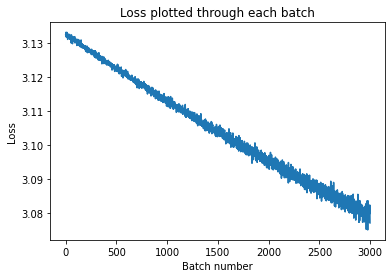

In [4]:
# Plotting the loss through the epochs
plt.plot(loss_list)
#plt.scatter(range(len(loss_list)), loss_list)
plt.title("Loss plotted through each batch")
plt.ylabel("Loss")
plt.xlabel("Batch number")
#plt.yscale("log")
#plt.xscale("log")
plt.savefig("loss_log.png")

In [5]:
# Predicting
accuracies = []
with torch.no_grad():
    # Loading saved model from file
    model.load_state_dict(torch.load("model.pth"))
    #model.eval()

    # Initalising data generator
    #dataset = Dataset(small_file, max_seq_len, acids=acids)
    #base_generator = data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=8)

    correct = 0
    
    # For loops is easiest way to get an element from
    # the generator even though we only loop once
    for i, (batch, labels, valid_elems) in enumerate(base_generator):
        test = batch
        batch = batch.to(processor)
        labels = labels.to(processor)

        # Transposing from (batch x seq x feature_size) to (seq x batch x feature_size)
        batch = batch.transpose(0,1)
        #labels = torch.transpose(labels, 0, 1)

        batch = rnn.pack_padded_sequence(batch, valid_elems, enforce_sorted=False)

        out, hidden = model(batch)

        out = out.transpose(0,1)

        print(out.size())
        print(valid_elems.size())
        for j in range(batch_size):
            preds = torch.argmax(out[j], dim=1)[:valid_elems[j]]
            actual = labels[j][:valid_elems[j]]
            truths = [1 if pred == truth else 0 for pred, truth in zip(preds, actual)]
            correct += sum(truths)
        accuracy = correct/(torch.sum(valid_elems).item())
        break
    
print("Test Accuracy: {0:.3f}%".format(accuracy*100))
print(labels.size())

#print(torch.argmax(out[0], dim=1))
#print(torch.max(out[0,:10], dim=1))
#print(torch.argmax(out[0,:10], dim=1))
#print(out[0,:10])

print_seq(out[0].view(1,out.size()[1], out.size()[2]), valid_elems, acids)
print_seq(test[0].view(1,test.size()[1], test.size()[2]), valid_elems, acids)

#print_seq(out, valid_elems)


torch.Size([32, 2000, 23])
torch.Size([32])


Test Accuracy: 9.495%
torch.Size([32, 2000])
Sequence 0
VLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL
Sequence 0
LQPMAIALAAVADGTSMITENVFEARLAFVEEMIRLGADARTDGHHAVVRGIPQLSSAPVWSSDIRAGAGLVLAGLVADGETEVHDVFHIDRGYRLFVENLLSLGAEIERVGS-
